In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import catboost
from catboost import CatBoostRegressor 
import shap
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, optimizers

In [4]:
Data = pd.read_excel(r'Combined.xlsx')

In [5]:
Data = Data.iloc[:,2:]

In [6]:
Data.head()

,Water Inflow,Reservoir Level,Temperature,Sediment Inflow,Precipitation,Average Seepage
0,13.206452,1419.231935,9.1,23250.51,23.2,7.553333
1,17.971429,1393.803214,10.5,93871.71,172.3,7.105000
2,24.716129,1375.466452,13.9,104541.84,96.0,5.950000
3,39.796552,1376.022414,20.1,481783.41,62.4,5.515000
4,90.090625,1380.776562,23.3,7206323.76,51.4,4.076000


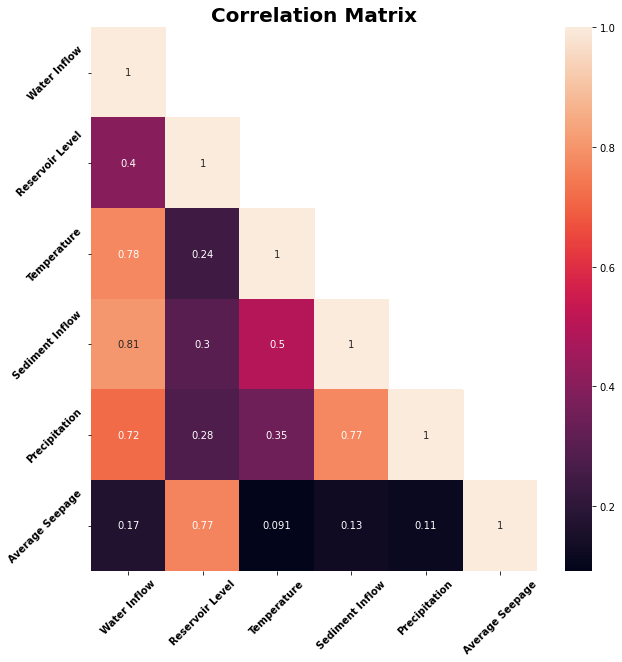

In [7]:
plt.figure(figsize=(10,10))
corr = Data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
np.fill_diagonal(mask, False)
sns.heatmap(corr,annot=True,mask=mask)
plt.xticks(rotation=45,weight='bold')
plt.yticks(rotation=45,weight='bold')
plt.title('Correlation Matrix',size=20,weight='bold')
plt.savefig('HeatMap',dpi=100,bbox_inches='tight')

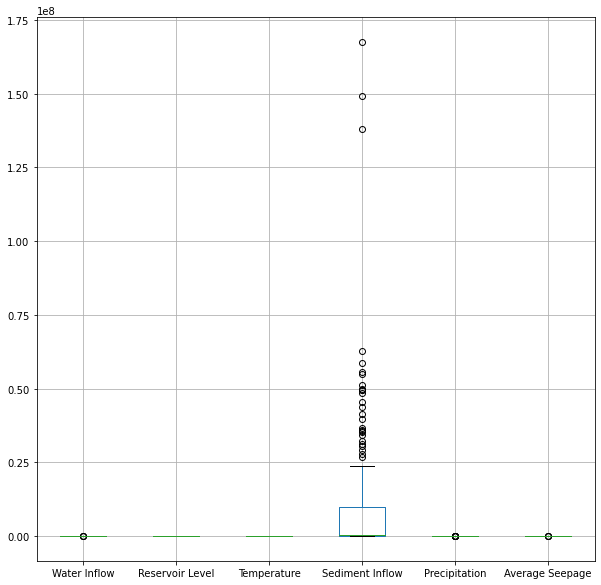

In [8]:
plt.figure(figsize=(10,10))
Data.boxplot()

In [9]:
a = Data.describe()
a.to_excel('Statistics.xlsx')

In [10]:
Scale_X = MinMaxScaler()
Scale_Y = MinMaxScaler()

X = Data.iloc[:,:-1]
Y = Data.iloc[:,-1].values.reshape(-1,1)

X = Scale_X.fit_transform(X)
Y = Scale_Y.fit_transform(Y)

In [11]:
Y = Y.reshape(1,-1)[0]

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_tes, Y_train, Y_tes = train_test_split(X, Y, test_size=0.3,random_state=13)
X_val, X_test, Y_val, Y_test = train_test_split(X_tes, Y_tes, test_size=0.5,random_state=4)

In [30]:
X_train['Average Seepage'] = Y_train
train = X_train.describe()
train.to_excel('Train.xlsx')

In [31]:
X_test['Average Seepage'] = Y_test
Val = X_test.describe()
Val.to_excel('Val.xlsx')

In [32]:
X_val['Average Seepage'] = Y_val
Test = X_val.describe()
Test.to_excel('Test.xlsx')

In [15]:
rf_default = RandomForestRegressor(n_estimators=100,max_depth=5,random_state=8)
rf_default.fit(X_train,Y_train)
print(rf_default.score(X_train,Y_train))
print(rf_default.score(X_test,Y_test))
rf_default.score(X_val,Y_val)

0.884271487690648
0.8018133134536873


0.7824331073313096

In [16]:
pred_train = rf_default.predict(X_train)
pred_test = rf_default.predict(X_test)
pred_val = rf_default.predict(X_val)

In [17]:
print(np.sqrt(np.mean((Y_train-pred_train)**2)))
print(np.sqrt(np.mean((Y_test-pred_test)**2)))
np.sqrt(np.mean((Y_val-pred_val)**2))

0.05957179950626369
0.07732811135617841


0.10924094601801088

# NSE RF

In [18]:
def nse(targets,predictions):
    return 1-(np.sum((targets-predictions)**2)/np.sum((targets-np.mean(predictions))**2))

nserf1 = nse(Y_train,pred_train)
nserf2 = nse(Y_test,pred_test)
nserf3 = nse(Y_val,pred_val)
print(nserf1)
print(nserf2)
print(nserf3)

0.8843191043501436
0.8031752597535925
0.7825204614106063


In [19]:
'When NSE = 1.0, then it shows a perfect fit. NSE > 0.75 is a very good fit, NSE = 0.64–0.74 is a good fit' 
'NSE = 0.5–0.64 is a satisfactory fit, and NSE < 0.5 is an unsatisfactory fit'

'NSE = 0.5–0.64 is a satisfactory fit, and NSE < 0.5 is an unsatisfactory fit'

In [20]:
Y_act = list(Y_train) + list(Y_test) + list(Y_val)

Y_pred = list(pred_train) + list(pred_test) + list(pred_val)

D = {'Seepage':Y_act}
D2 = {'Seepage':Y_pred}

Y_transformed_act = pd.DataFrame(D)
Y_transformed_pred = pd.DataFrame(D2)

Y_act = Scale_Y.inverse_transform(Y_transformed_act)
Y_pred = Scale_Y.inverse_transform(Y_transformed_pred)

Yy = Y_act[:,0]
Py = Y_pred[:,0]

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


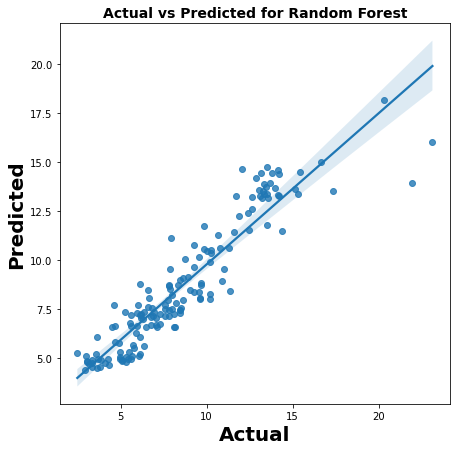

In [21]:
plt.figure(figsize=(7,7))
sns.regplot(Yy,Py)
plt.title('Actual vs Predicted for Random Forest',size=14,weight='bold')
plt.xlabel('Actual',size=20,weight='bold')
plt.ylabel('Predicted',size=20,weight='bold')
plt.savefig('Regplot Random Forest',dpi=100,bbox_inches='tight')

In [22]:
le = np.arange(12,166,12)
Years = ['2003','2004','2005','2006','2007','2008','2009','2010',
         '2011','2012','2013','2014','2015','2016']

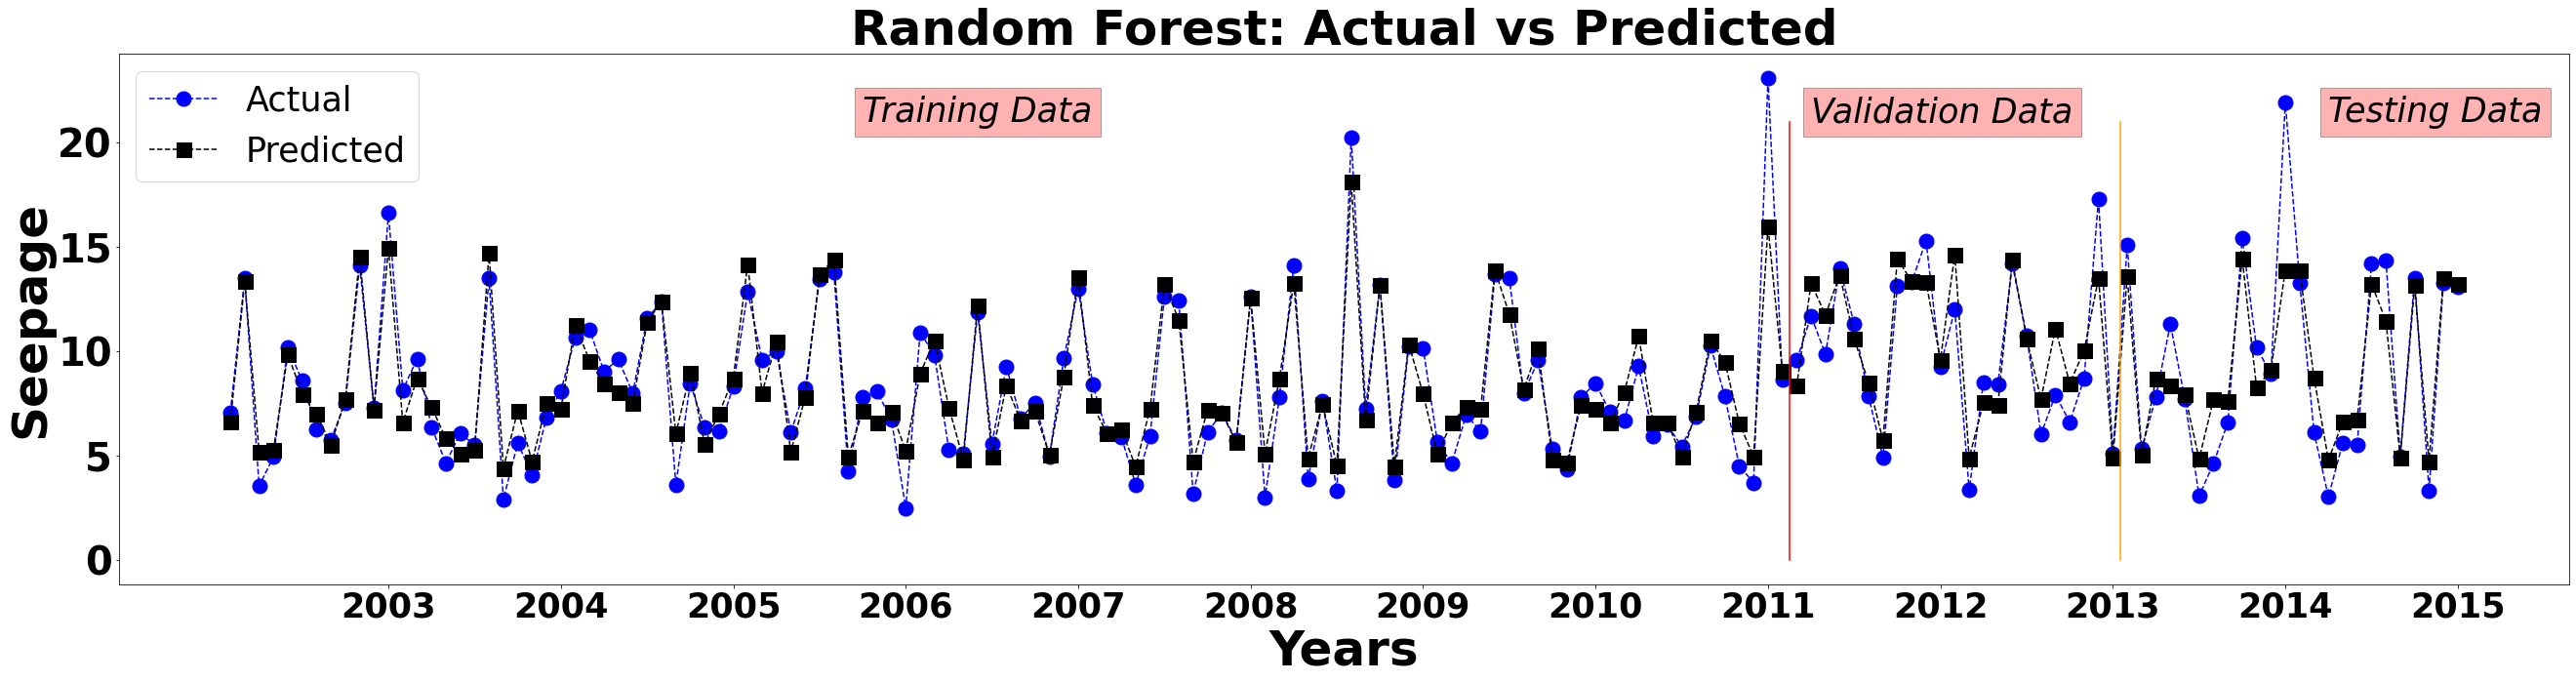

In [23]:
plt.figure(figsize=(45,10))
plt.plot(range(1,len(Data.iloc[:,0])+1),Yy,marker='o',markersize=15,linestyle='dashed',color='blue',label='Actual')
plt.plot(range(1,len(Data.iloc[:,0])+1),Py,marker='s',markersize=15,linestyle='dashed',color='black',label='Predicted')
plt.xlabel('Years',size=50,weight='bold')
plt.ylabel("Seepage",size=50,weight='bold')
plt.title('Random Forest: Actual vs Predicted',size=50,weight='bold')
plt.xticks(size=35)
plt.xticks(le,Years,weight='bold')
plt.yticks(size=40,weight='bold')
x1, y1 = [109.5, 109.5], [0, 21]
plt.plot(x1,y1,color='red')
x2, y2 = [132.5, 132.5], [0, 21]
plt.plot(x2,y2,color='orange')
plt.legend(prop={"size":35},loc='upper left')
plt.text(45, 21, 'Training Data', style='italic', bbox={'facecolor': 'red', 'alpha': 0.3, 'pad': 8},fontsize=35)
plt.text(111, 21, 'Validation Data', style='italic', bbox={'facecolor': 'red', 'alpha': 0.3, 'pad': 8},fontsize=35)
plt.text(147, 21, 'Testing Data', style='italic', bbox={'facecolor': 'red', 'alpha': 0.3, 'pad': 8},fontsize=35)
plt.savefig('Random Forest Actual vs Predicted',dpi=100,bbox_inches='tight')
plt.show()

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


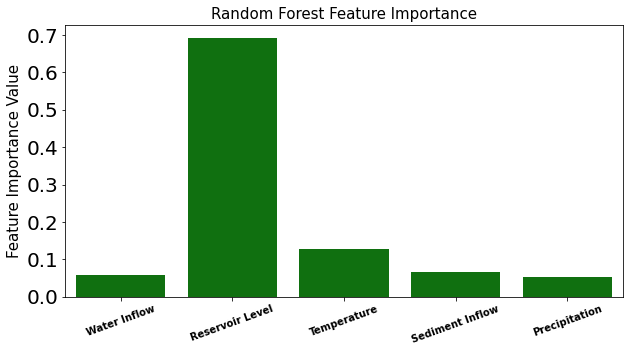

In [26]:
plt.figure(figsize=(10,5))
sns.barplot(np.arange(len(rf_default.feature_importances_)),rf_default.feature_importances_,color='green')
plt.ylabel("Feature Importance Value",size=15)
plt.title('Random Forest Feature Importance',size=15)
plt.xticks(np.arange(len(Data.columns[:-1])),labels=Data.columns[:-1],size=10,weight='bold',rotation=20)
plt.yticks(size=20)
plt.savefig('Random Forest Feature Importance',dpi=100,bbox_inches='tight')

In [33]:
#categorical_features = np.where(X.dtypes != np.float)[0]

params = {'iterations':5000,
        'learning_rate':0.01,
        'depth':5,
        'eval_metric':'R2',
        'verbose':200,
        'od_type':"Iter", # overfit detector
        'od_wait':1000, # most recent best iteration to wait before stopping
        'random_seed': 2
          }

cat_model = CatBoostRegressor(**params)
cat_model.fit(X_train, Y_train,   
          eval_set=(X_test, Y_test), 
          use_best_model=True, # True if we don't want to save trees created after iteration with the best validation score
          plot=True );

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0079353	test: -0.3019116	best: -0.3019116 (0)	total: 151ms	remaining: 12m 32s
200:	learn: 0.5985772	test: 0.6809147	best: 0.6810958 (199)	total: 255ms	remaining: 6.09s
400:	learn: 0.7294797	test: 0.7613073	best: 0.7625968 (395)	total: 358ms	remaining: 4.11s
600:	learn: 0.7979019	test: 0.7824526	best: 0.7824526 (600)	total: 479ms	remaining: 3.5s
800:	learn: 0.8446022	test: 0.7949673	best: 0.7949673 (800)	total: 581ms	remaining: 3.05s
1000:	learn: 0.8874384	test: 0.8018247	best: 0.8018416 (996)	total: 689ms	remaining: 2.75s
1200:	learn: 0.9144076	test: 0.8051665	best: 0.8051665 (1200)	total: 791ms	remaining: 2.5s
1400:	learn: 0.9341731	test: 0.8045748	best: 0.8057057 (1279)	total: 941ms	remaining: 2.42s
1600:	learn: 0.9488977	test: 0.8040109	best: 0.8057057 (1279)	total: 1.09s	remaining: 2.32s
1800:	learn: 0.9610736	test: 0.8029803	best: 0.8057057 (1279)	total: 1.34s	remaining: 2.38s
2000:	learn: 0.9693813	test: 0.8014667	best: 0.8057057 (1279)	total: 1.61s	remaining: 2.41s
2

In [22]:
cat_predict = cat_model.predict(X_val)

In [84]:
cat_model.best_score_

{'learn': {'R2': 0.9787730665830461, 'RMSE': 0.025513154806753237},
 'validation': {'R2': 0.8057057118698514, 'RMSE': 0.07656498162544022}}

In [23]:
cat_model.best_score_

{'learn': {'R2': 0.9787730665830461, 'RMSE': 0.025513154806753237},
 'validation': {'R2': 0.8057057118698514, 'RMSE': 0.07656498162544022}}

In [85]:
r2_score(Y_val,cat_predict)

0.7733642116475635

In [86]:
np.sqrt(np.mean((Y_val-cat_predict)**2))

0.1114944612607816

In [87]:
cat_model.feature_importances_

array([12.56057791, 55.14282816,  9.91454299, 10.90482099, 11.47722994])

In [88]:
Data.columns[:-1]

Index(['Water Inflow', 'Reservoir Level', 'Temperature', 'Sediments Inflow',
       'Precipitation'],
      dtype='object')

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


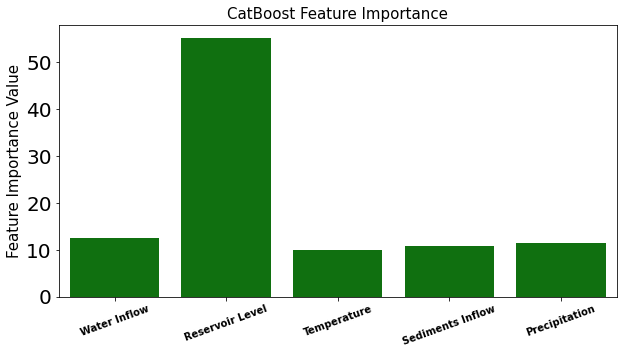

In [89]:
plt.figure(figsize=(10,5))
sns.barplot(np.arange(len(cat_model.feature_importances_)),cat_model.feature_importances_,color='green')
plt.ylabel("Feature Importance Value",size=15)
plt.title('CatBoost Feature Importance',size=15)
plt.xticks(np.arange(len(Data.columns[:-1])),labels=Data.columns[:-1],size=10,weight='bold',rotation=20)
plt.yticks(size=20)
plt.savefig('CatBoost Actual Feature Importance',dpi=100,bbox_inches='tight')

In [34]:
preds_train = cat_model.predict(X_train)
preds_test = cat_model.predict(X_test)
preds_val = cat_model.predict(X_val)

# NSE CB

In [35]:
nsecb1 = nse(Y_train,pred_train)
nsecb2 = nse(Y_test,preds_test)
nsecb3 = nse(Y_val,preds_val)
print(nsecb1)
print(nsecb2)
print(nsecb3)

0.8843191043501436
0.8058213380740673
0.77457708895983


In [91]:
Y_act = list(Y_train) + list(Y_test) + list(Y_val)

Y_pred = list(preds_train) + list(preds_test) + list(preds_val)

D = {'Seepage':Y_act}
D2 = {'Seepage':Y_pred}

Y_transformed_act = pd.DataFrame(D)
Y_transformed_pred = pd.DataFrame(D2)

Y_act = Scale_Y.inverse_transform(Y_transformed_act)
Y_pred = Scale_Y.inverse_transform(Y_transformed_pred)

Yy = Y_act[:,0]
Py = Y_pred[:,0]

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


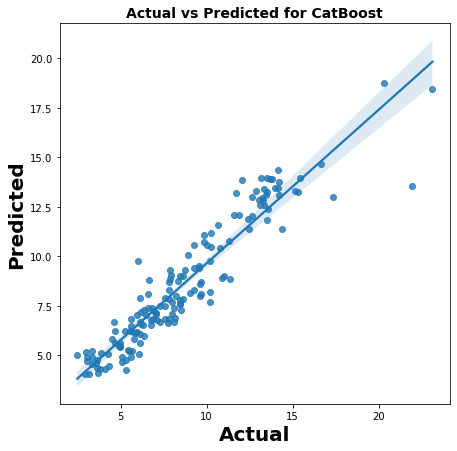

In [92]:
plt.figure(figsize=(7,7))
sns.regplot(Yy,Py)
plt.title('Actual vs Predicted for CatBoost',size=14,weight='bold')
plt.xlabel('Actual',size=20,weight='bold')
plt.ylabel('Predicted',size=20,weight='bold')
plt.savefig('Regplot CatBoost',dpi=100,bbox_inches='tight')

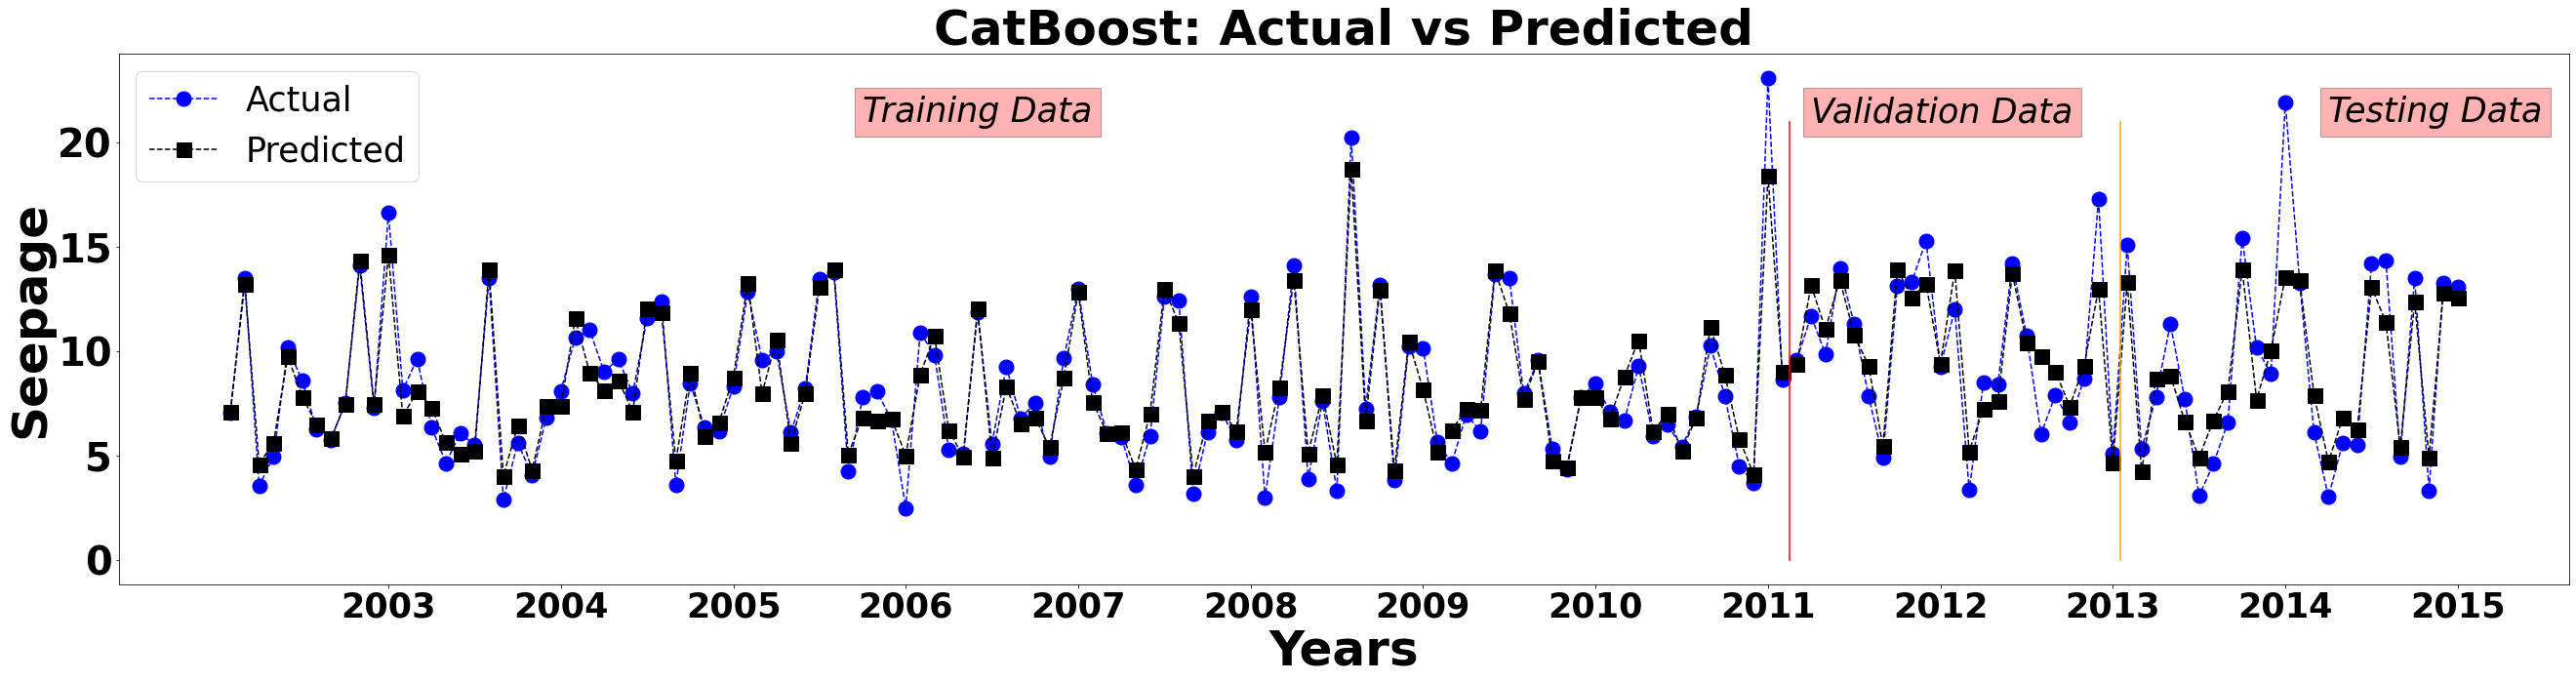

In [93]:
plt.figure(figsize=(45,10))
plt.plot(range(1,len(Data.iloc[:,0])+1),Yy,marker='o',markersize=15,linestyle='dashed',color='blue',label='Actual')
plt.plot(range(1,len(Data.iloc[:,0])+1),Py,marker='s',markersize=15,linestyle='dashed',color='black',label='Predicted')
plt.xlabel('Years',size=50,weight='bold')
plt.ylabel("Seepage",size=50,weight='bold')
plt.title('CatBoost: Actual vs Predicted',size=50,weight='bold')
plt.xticks(size=35)
plt.xticks(le,Years,weight='bold')
plt.yticks(size=40,weight='bold')
x1, y1 = [109.5, 109.5], [0, 21]
plt.plot(x1,y1,color='red')
x2, y2 = [132.5, 132.5], [0, 21]
plt.plot(x2,y2,color='orange')
plt.legend(prop={"size":35},loc='upper left')
plt.text(45, 21, 'Training Data', style='italic', bbox={'facecolor': 'red', 'alpha': 0.3, 'pad': 8},fontsize=35)
plt.text(111, 21, 'Validation Data', style='italic', bbox={'facecolor': 'red', 'alpha': 0.3, 'pad': 8},fontsize=35)
plt.text(147, 21, 'Testing Data', style='italic', bbox={'facecolor': 'red', 'alpha': 0.3, 'pad': 8},fontsize=35)
plt.savefig('CatBoost Actual vs Predicted',dpi=100,bbox_inches='tight')
plt.show()

In [29]:
X = pd.DataFrame(X)
Y = pd.DataFrame(Y)

X.columns = Data.columns[:-1]
X.head(3)

,Water Inflow,Reservoir Level,Temperature,Sediment Inflow,Precipitation
0,0.000000,0.292043,0.084821,0.000000,0.044667
1,0.013840,0.154293,0.147321,0.000422,0.348766
2,0.033429,0.054961,0.299107,0.000485,0.193147


In [30]:
all_preds = rf_default.predict(X)


X_df = pd.DataFrame(X)

x_df = X_df.copy(deep=True)
x_df_1st = x_df.copy(deep=True)

x_df_1st['1st'] = all_preds

x_df = x_df.reset_index().drop('index',axis=1)
x_df_1st = x_df_1st.reset_index().drop('index',axis=1)


shap_values = shap.TreeExplainer(rf_default).shap_values(x_df)
#shap.summary_plot(shap_values, x_df)

X has feature names, but RandomForestRegressor was fitted without feature names


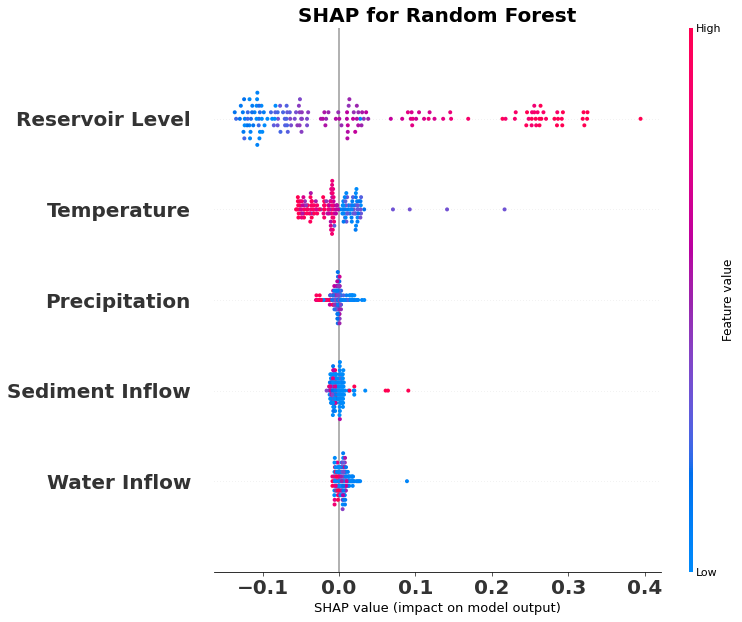

In [31]:
'Effect of input parameters on Pmax'
shap.summary_plot(shap_values, x_df,plot_size=(10,10),show=False,plot_type='dot')
plt.title('SHAP for Random Forest',weight='bold',size=20)
plt.xticks(size=20,weight='bold')
plt.yticks(size=20,weight='bold')
plt.savefig('SHAP',dpi=100,bbox_inches='tight')

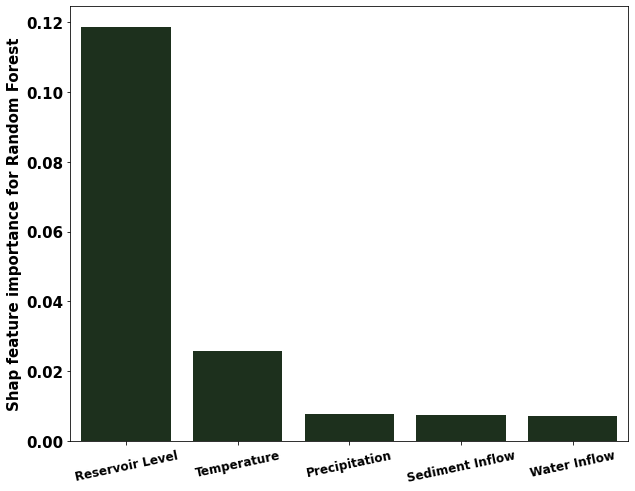

In [32]:
shap_values = shap.TreeExplainer(rf_default).shap_values(x_df)
feature_imp = np.mean(np.abs(shap_values),axis=0)
feature_imp.shape

# top 20 important features
ind = feature_imp.argsort()[-20:]
ind = ind[::-1] #arranging in descending order

np.array(x_df.columns)[ind]
feature_imp[ind]

plt.figure(figsize=(10,8))
plot = sns.barplot(x=np.array(x_df.columns)[ind],y=feature_imp[ind],color=[0.1,0.2,0.1])
plot.set_xticklabels(plot.get_xticklabels(), horizontalalignment='center',size=12)
plt.yticks(size=15,weight='bold')
plt.xticks(size=12,rotation=12,weight='bold')
plt.ylabel('Shap feature importance for Random Forest',size=15,weight='bold')
plt.savefig('SHAP Feature Importance RF',dpi=100,bbox_inches='tight')

# SHAP For CatBoost

In [36]:
all_preds = cat_model.predict(X)


X_df = pd.DataFrame(X)

x_df = X_df.copy(deep=True)
x_df_1st = x_df.copy(deep=True)

x_df_1st['1st'] = all_preds

x_df = x_df.reset_index().drop('index',axis=1)
x_df_1st = x_df_1st.reset_index().drop('index',axis=1)


shap_values_2 = shap.TreeExplainer(cat_model).shap_values(x_df)
#shap.summary_plot(shap_values, x_df)

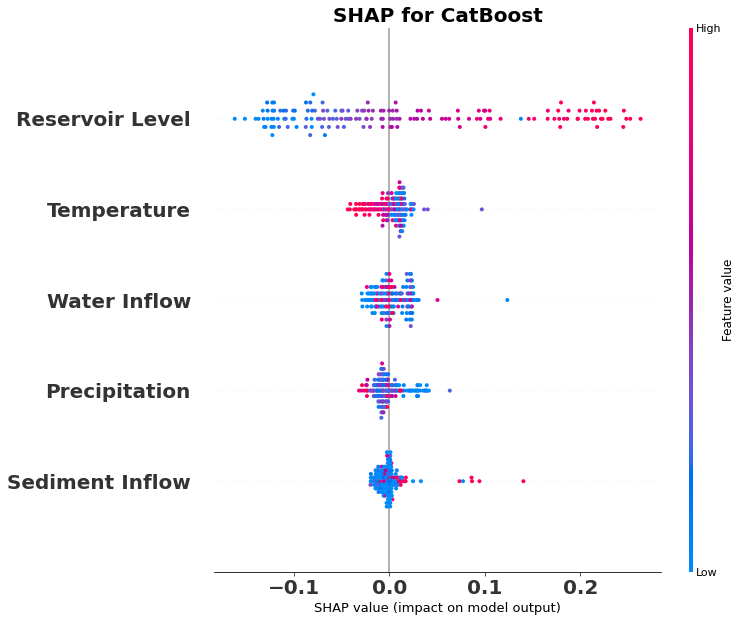

In [37]:
'Effect of input parameters on Pmax'
shap.summary_plot(shap_values_2, x_df,plot_size=(10,10),show=False,plot_type='dot')
plt.title('SHAP for CatBoost',weight='bold',size=20)
plt.xticks(size=20,weight='bold')
plt.yticks(size=20,weight='bold')
plt.savefig('SHAP_Catboost',dpi=100,bbox_inches='tight')

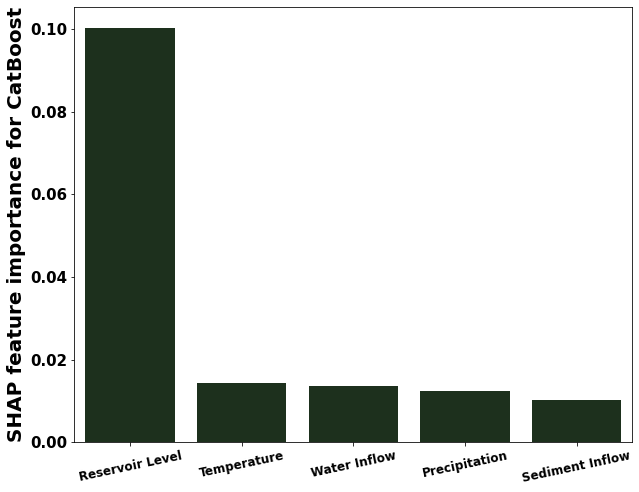

In [38]:
feature_imp = np.mean(np.abs(shap_values_2),axis=0)
feature_imp.shape

# top 20 important features
ind = feature_imp.argsort()[-20:]
ind = ind[::-1] #arranging in descending order

np.array(x_df.columns)[ind]
feature_imp[ind]

plt.figure(figsize=(10,8))
plot = sns.barplot(x=np.array(x_df.columns)[ind],y=feature_imp[ind],color=[0.1,0.2,0.1])
plot.set_xticklabels(plot.get_xticklabels(), horizontalalignment='center',size=12)
plt.yticks(size=15,weight='bold')
plt.xticks(size=12,rotation=12,weight='bold')
plt.ylabel('SHAP feature importance for CatBoost',size=20,weight='bold')
plt.savefig('SHAP Feature Importance Catboost',dpi=100,bbox_inches='tight')

# Gradient Boosting

In [75]:
from sklearn.ensemble import GradientBoostingRegressor

In [76]:
Ada = GradientBoostingRegressor(random_state=42)
Ada.fit(X_train,Y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


GradientBoostingRegressor(random_state=42)

In [77]:
Ada.score(X_test,Y_test)

0.8023744771826014

In [78]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [2,5,6,10],'n_estimators': [10,20,30,50,100],
    'min_samples_split':[2,3,4],'min_samples_leaf':[1,2,3,4],'learning_rate':[0.1,0.01]}

ada = GradientBoostingRegressor(random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = ada, param_grid = param_grid, 
                          cv = 10, n_jobs = -1, verbose = 2,scoring='r2')


# Fit the grid search to the data
grid_search.fit(X_train, Y_train)
grid_search.best_params_

best_grid_GBT = grid_search.best_estimator_
#print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

best_grid_GBT

Fitting 10 folds for each of 480 candidates, totalling 4800 fits


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


GradientBoostingRegressor(max_depth=2, min_samples_leaf=3, n_estimators=30,
                          random_state=42)

In [79]:
best_grid_GBT.score(X_test,Y_test)

0.7376633749162279

In [80]:
best_grid_GBT.score(X_val,Y_val)

0.7442574403307549

In [81]:
grid_search.best_score_

0.566263185465452

In [53]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=1)
neigh.fit(X_train,Y_train)
print(neigh.score(X_train,Y_train))
print(neigh.score(X_test,Y_test))
neigh.score(X_val,Y_val)

1.0
0.6027707515193466


0.7258336078956529

In [58]:
# Create the parameter grid based on the results of random search 
param_grid = {'n_neighbors':[2,5,7,10,15,20],'algorithm' : ['ball_tree', 'kd_tree', 'brute']}

neigh = KNeighborsRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = neigh, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2,scoring='r2')


# Fit the grid search to the data
grid_search.fit(X_train, Y_train)
grid_search.best_params_

best_grid_KNN = grid_search.best_estimator_
#print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

best_grid_KNN

Fitting 5 folds for each of 18 candidates, totalling 90 fits


KNeighborsRegressor(algorithm='ball_tree', n_neighbors=20)

In [57]:
best_grid_KNN.score(X_train,Y_train)

0.4896595461243344

In [55]:
best_grid_KNN.score(X_test,Y_test)

0.5977358307869509

In [56]:
best_grid_KNN.score(X_val,Y_val)

0.6772316156654383

In [197]:
X_train, X_tes, Y_train, Y_tes = train_test_split(X, Y, test_size=0.3,random_state=13)
X_val, X_test, Y_val, Y_test = train_test_split(X_tes, Y_tes, test_size=0.5,random_state=4)

# SVR

In [39]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

In [40]:
SVR = svm.SVR(kernel='rbf',degree=2,C=4,tol=0.001,gamma=1)
#SVR = svm.SVR()
SVR.fit(X_train,Y_train)
print(SVR.score(X_train,Y_train))
print(SVR.score(X_test,Y_test))
SVR.score(X_val,Y_val)

0.602681302075567
0.7811299747682531


0.7705768826606442

In [126]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'kernel': ['poly', 'rbf'],'degree': [2,3,4,5],'C':[0.1,0.5,1,2,3],
    'tol':[0.1,0.01,0.001],'gamma':[0.5,1,2,3,4,5]}

ada = svm.SVR()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = ada, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2,scoring='r2')


# Fit the grid search to the data
grid_search.fit(X_train, Y_train)
grid_search.best_params_

best_grid_SVR = grid_search.best_estimator_
#print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

best_grid_SVR

In [41]:
m = svm.SVR(C=0.1, degree=2, gamma=2, kernel='poly', tol=0.01)

In [42]:
#m = best_grid_SVR.fit(X_train,Y_train)
m.fit(X_train,Y_train)
print(m.score(X_train,Y_train))
print(m.score(X_test,Y_test))
print(m.score(X_val,Y_val))

0.5914930338504589
0.7940947801794888
0.7835546286115648


In [43]:
pred_train = m.predict(X_train)
pred_test = m.predict(X_test)
pred_val = m.predict(X_val)

In [44]:
print(np.sqrt(np.mean((Y_train-pred_train)**2)))
print(np.sqrt(np.mean((Y_test-pred_test)**2)))
np.sqrt(np.mean((Y_val-pred_val)**2))

0.1119232383623193
0.07881953038781228


0.10895902274405617

# NSE SVR

In [34]:
nsecb1 = nse(Y_train,pred_train)
nsecb2 = nse(Y_test,pred_test)
nsecb3 = nse(Y_val,pred_val)
print(nsecb1)
print(nsecb2)
print(nsecb3)

0.5916764362495341
0.7985801228000126
0.7839045150156999


In [109]:
m

SVR(C=0.1, degree=2, gamma=2, kernel='poly', tol=0.01)

In [45]:
svm_explainer = shap.KernelExplainer(m.predict,X)
svm_shap_values = svm_explainer.shap_values(X)

Using 156 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/156 [00:00<?, ?it/s]

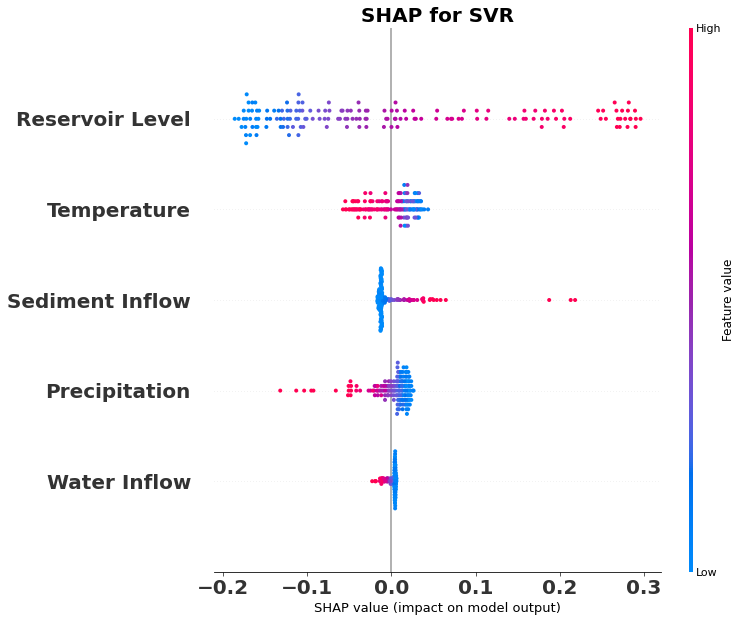

In [46]:
'Effect of input parameters on Pmax'
shap.summary_plot(svm_shap_values, x_df,plot_size=(10,10),show=False,plot_type='dot')
plt.title('SHAP for SVR',weight='bold',size=20)
plt.xticks(size=20,weight='bold')
plt.yticks(size=20,weight='bold')
plt.savefig('SHAP_SVR',dpi=100,bbox_inches='tight')

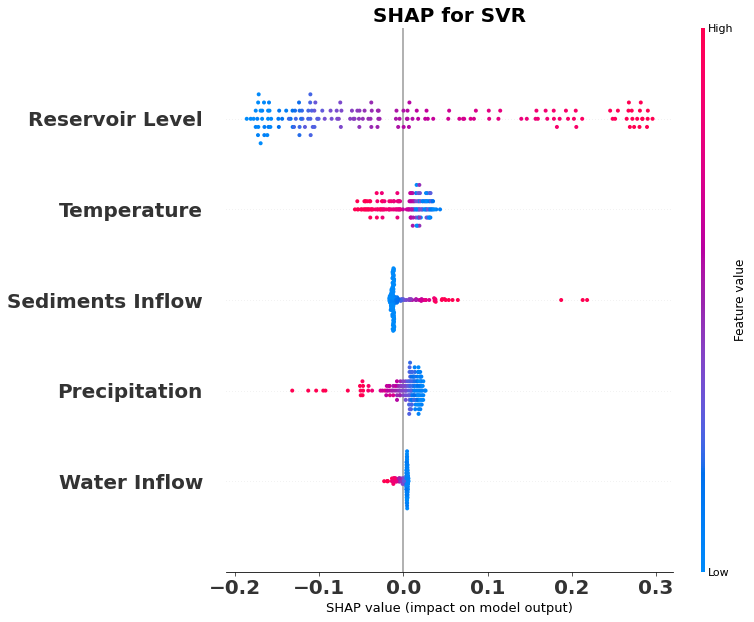

In [111]:
'Effect of input parameters on Pmax'
shap.summary_plot(svm_shap_values, x_df,plot_size=(10,10),show=False,plot_type='dot')
plt.title('SHAP for SVR',weight='bold',size=20)
plt.xticks(size=20,weight='bold')
plt.yticks(size=20,weight='bold')
plt.savefig('SHAP_SVR',dpi=100,bbox_inches='tight')

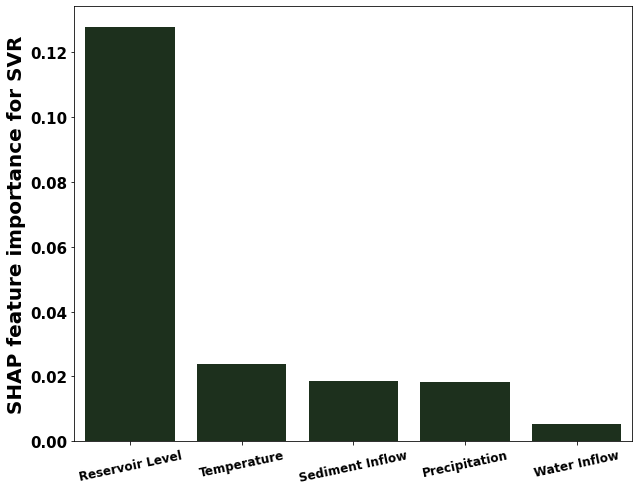

In [47]:
feature_imp = np.mean(np.abs(svm_shap_values),axis=0)
feature_imp.shape

# top 20 important features
ind = feature_imp.argsort()[-20:]
ind = ind[::-1] #arranging in descending order

np.array(x_df.columns)[ind]
feature_imp[ind]

plt.figure(figsize=(10,8))
plot = sns.barplot(x=np.array(x_df.columns)[ind],y=feature_imp[ind],color=[0.1,0.2,0.1])
plot.set_xticklabels(plot.get_xticklabels(), horizontalalignment='center',size=12)
plt.yticks(size=15,weight='bold')
plt.xticks(size=12,rotation=12,weight='bold')
plt.ylabel('SHAP feature importance for SVR',size=20,weight='bold')
plt.savefig('SHAP Feature Importance SVR',dpi=100,bbox_inches='tight')

In [113]:
Y_act = list(Y_train) + list(Y_test) + list(Y_val)

Y_pred = list(preds_train) + list(pred_test) + list(pred_val)

D = {'Seepage':Y_act}
D2 = {'Seepage':Y_pred}

Y_transformed_act = pd.DataFrame(D)
Y_transformed_pred = pd.DataFrame(D2)

Y_act = Scale_Y.inverse_transform(Y_transformed_act)
Y_pred = Scale_Y.inverse_transform(Y_transformed_pred)

Yy = Y_act[:,0]
Py = Y_pred[:,0]

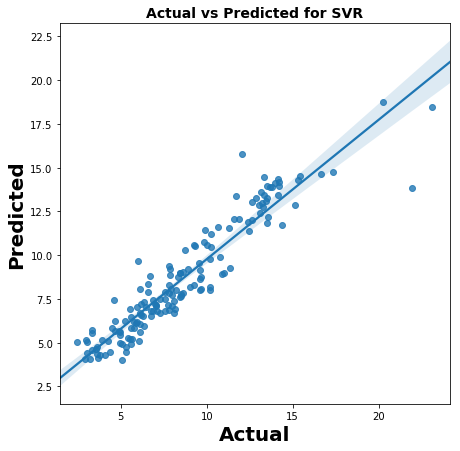

In [123]:
plt.figure(figsize=(7,7))
sns.regplot(Yy,Py)
plt.title('Actual vs Predicted for SVR',size=14,weight='bold')
plt.xlabel('Actual',size=20,weight='bold')
plt.ylabel('Predicted',size=20,weight='bold')
plt.savefig('Regplot SVR',dpi=100,bbox_inches='tight')

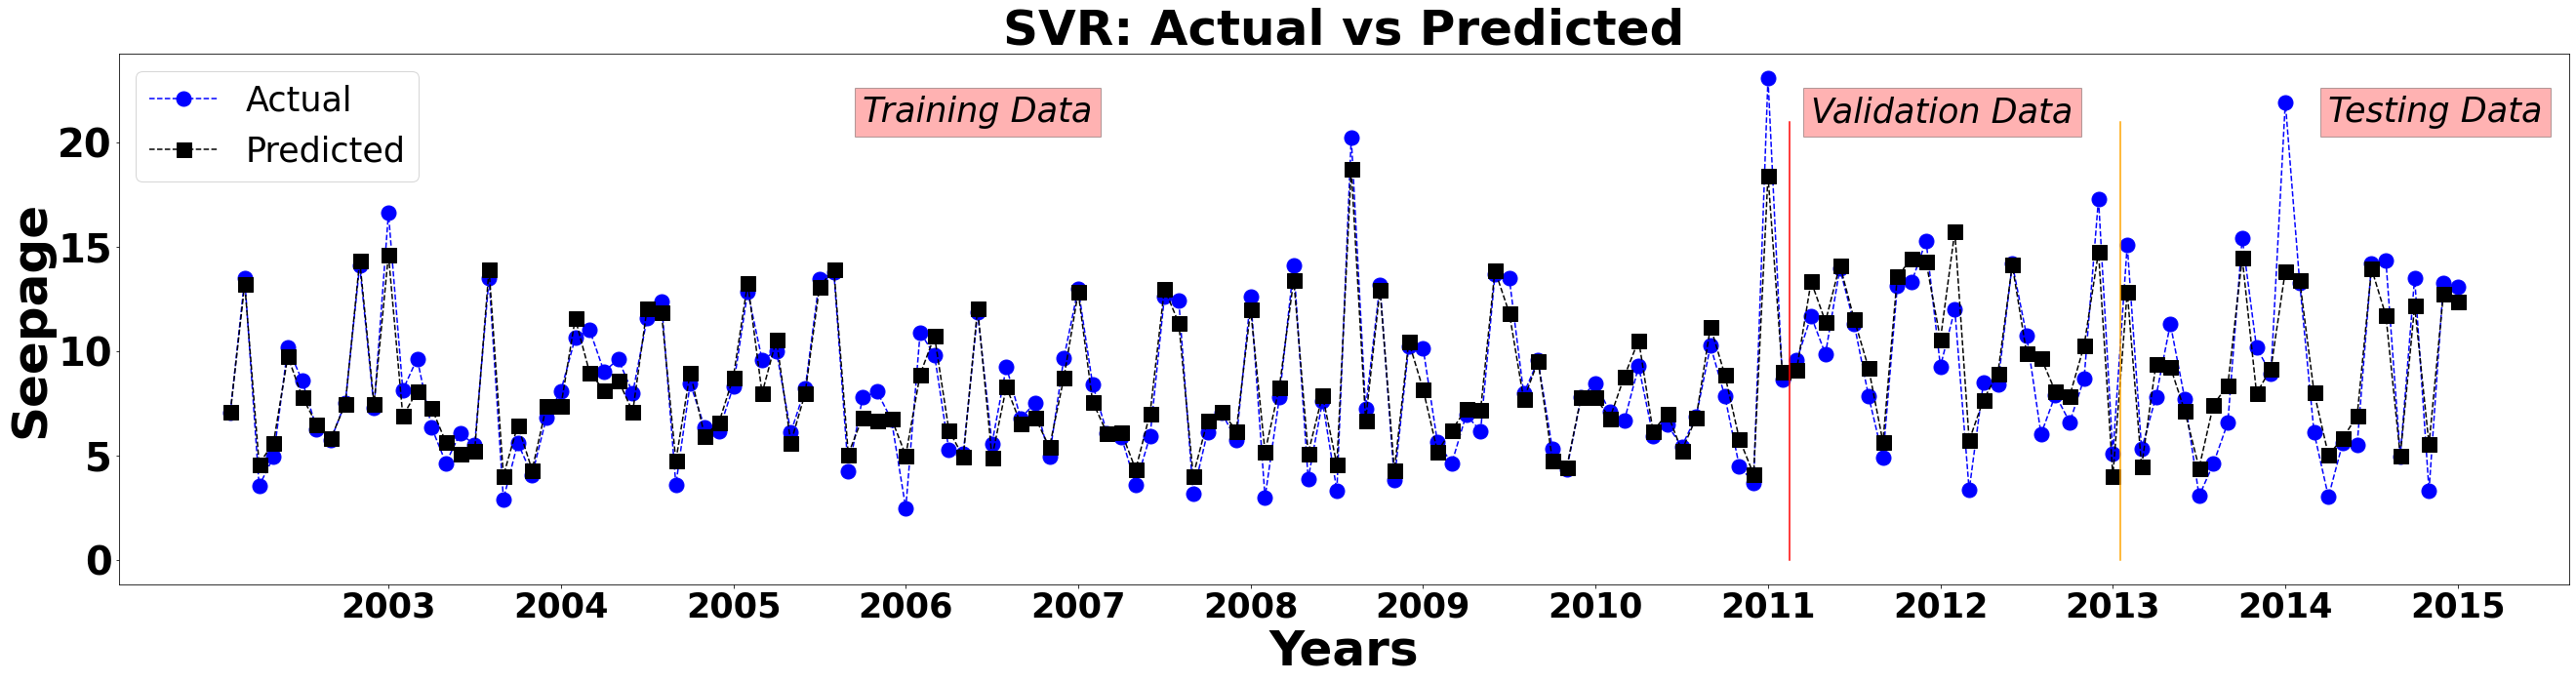

In [114]:
plt.figure(figsize=(45,10))
plt.plot(range(1,len(Data.iloc[:,0])+1),Yy,marker='o',markersize=15,linestyle='dashed',color='blue',label='Actual')
plt.plot(range(1,len(Data.iloc[:,0])+1),Py,marker='s',markersize=15,linestyle='dashed',color='black',label='Predicted')
plt.xlabel('Years',size=50,weight='bold')
plt.ylabel("Seepage",size=50,weight='bold')
plt.title('SVR: Actual vs Predicted',size=50,weight='bold')
plt.xticks(size=35)
plt.xticks(le,Years,weight='bold')
plt.yticks(size=40,weight='bold')
x1, y1 = [109.5, 109.5], [0, 21]
plt.plot(x1,y1,color='red')
x2, y2 = [132.5, 132.5], [0, 21]
plt.plot(x2,y2,color='orange')
plt.legend(prop={"size":35},loc='upper left')
plt.text(45, 21, 'Training Data', style='italic', bbox={'facecolor': 'red', 'alpha': 0.3, 'pad': 8},fontsize=35)
plt.text(111, 21, 'Validation Data', style='italic', bbox={'facecolor': 'red', 'alpha': 0.3, 'pad': 8},fontsize=35)
plt.text(147, 21, 'Testing Data', style='italic', bbox={'facecolor': 'red', 'alpha': 0.3, 'pad': 8},fontsize=35)
plt.savefig('SVR Actual vs Predicted',dpi=100,bbox_inches='tight')
plt.show()

# ANN

In [78]:
model = models.Sequential()
model.add(layers.Dense(100, input_dim = len(Data.columns[:-1]), activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['mae'])
model.fit(X_train, Y_train, epochs=2000, batch_size=20)

Epoch 1/2000
109/109 [==============================] - ETA: 0s - loss: 0.0969 - mean_absolute_error: 0.217 - 0s 1ms/sample - loss: 0.0308 - mean_absolute_error: 0.1241
Epoch 2/2000
109/109 [==============================] - ETA: 0s - loss: 0.0117 - mean_absolute_error: 0.088 - 0s 128us/sample - loss: 0.0197 - mean_absolute_error: 0.0978
Epoch 3/2000
109/109 [==============================] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.062 - 0s 119us/sample - loss: 0.0166 - mean_absolute_error: 0.0803
Epoch 4/2000
109/109 [==============================] - ETA: 0s - loss: 0.0146 - mean_absolute_error: 0.085 - 0s 128us/sample - loss: 0.0154 - mean_absolute_error: 0.0771
Epoch 5/2000
109/109 [==============================] - ETA: 0s - loss: 0.0455 - mean_absolute_error: 0.107 - 0s 119us/sample - loss: 0.0155 - mean_absolute_error: 0.0804
Epoch 6/2000
109/109 [==============================] - ETA: 0s - loss: 0.0083 - mean_absolute_error: 0.076 - 0s 110us/sample - loss: 0.0154 - mean

Epoch 49/2000
109/109 [==============================] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.077 - 0s 119us/sample - loss: 0.0112 - mean_absolute_error: 0.0646
Epoch 50/2000
109/109 [==============================] - ETA: 0s - loss: 0.0042 - mean_absolute_error: 0.052 - 0s 119us/sample - loss: 0.0110 - mean_absolute_error: 0.0632
Epoch 51/2000
109/109 [==============================] - ETA: 0s - loss: 0.0360 - mean_absolute_error: 0.092 - 0s 147us/sample - loss: 0.0110 - mean_absolute_error: 0.0637
Epoch 52/2000
109/109 [==============================] - ETA: 0s - loss: 0.0039 - mean_absolute_error: 0.049 - 0s 124us/sample - loss: 0.0110 - mean_absolute_error: 0.0640
Epoch 53/2000
109/109 [==============================] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.073 - 0s 119us/sample - loss: 0.0111 - mean_absolute_error: 0.0668
Epoch 54/2000
109/109 [==============================] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.063 - 0s 119us/sample - loss: 0.011

109/109 [==============================] - ETA: 0s - loss: 0.0293 - mean_absolute_error: 0.088 - 0s 119us/sample - loss: 0.0100 - mean_absolute_error: 0.0662
Epoch 144/2000
109/109 [==============================] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.059 - 0s 119us/sample - loss: 0.0103 - mean_absolute_error: 0.0605
Epoch 145/2000
109/109 [==============================] - ETA: 0s - loss: 0.0018 - mean_absolute_error: 0.035 - 0s 124us/sample - loss: 0.0095 - mean_absolute_error: 0.0592
Epoch 146/2000
109/109 [==============================] - ETA: 0s - loss: 0.0033 - mean_absolute_error: 0.046 - 0s 119us/sample - loss: 0.0089 - mean_absolute_error: 0.0575
Epoch 147/2000
109/109 [==============================] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.057 - 0s 119us/sample - loss: 0.0089 - mean_absolute_error: 0.0561
Epoch 148/2000
109/109 [==============================] - ETA: 0s - loss: 0.0024 - mean_absolute_error: 0.039 - 0s 110us/sample - loss: 0.0091 - mean_

109/109 [==============================] - ETA: 0s - loss: 0.0033 - mean_absolute_error: 0.045 - 0s 110us/sample - loss: 0.0076 - mean_absolute_error: 0.0504
Epoch 238/2000
109/109 [==============================] - ETA: 0s - loss: 0.0048 - mean_absolute_error: 0.057 - 0s 119us/sample - loss: 0.0076 - mean_absolute_error: 0.0507
Epoch 239/2000
109/109 [==============================] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.041 - 0s 119us/sample - loss: 0.0074 - mean_absolute_error: 0.0503
Epoch 240/2000
109/109 [==============================] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.058 - 0s 119us/sample - loss: 0.0076 - mean_absolute_error: 0.0528
Epoch 241/2000
109/109 [==============================] - ETA: 0s - loss: 0.0029 - mean_absolute_error: 0.042 - 0s 105us/sample - loss: 0.0079 - mean_absolute_error: 0.0513
Epoch 242/2000
109/109 [==============================] - ETA: 0s - loss: 0.0024 - mean_absolute_error: 0.039 - 0s 110us/sample - loss: 0.0074 - mean_

109/109 [==============================] - ETA: 0s - loss: 0.0037 - mean_absolute_error: 0.049 - 0s 110us/sample - loss: 0.0066 - mean_absolute_error: 0.0513
Epoch 332/2000
109/109 [==============================] - ETA: 0s - loss: 0.0046 - mean_absolute_error: 0.049 - 0s 101us/sample - loss: 0.0065 - mean_absolute_error: 0.0494
Epoch 333/2000
109/109 [==============================] - ETA: 0s - loss: 0.0015 - mean_absolute_error: 0.030 - 0s 128us/sample - loss: 0.0063 - mean_absolute_error: 0.0457
Epoch 334/2000
109/109 [==============================] - ETA: 0s - loss: 0.0012 - mean_absolute_error: 0.027 - 0s 119us/sample - loss: 0.0060 - mean_absolute_error: 0.0459
Epoch 335/2000
109/109 [==============================] - ETA: 0s - loss: 0.0028 - mean_absolute_error: 0.038 - 0s 119us/sample - loss: 0.0062 - mean_absolute_error: 0.0472
Epoch 336/2000
109/109 [==============================] - ETA: 0s - loss: 0.0029 - mean_absolute_error: 0.032 - 0s 119us/sample - loss: 0.0062 - mean_

109/109 [==============================] - ETA: 0s - loss: 0.0036 - mean_absolute_error: 0.044 - 0s 110us/sample - loss: 0.0048 - mean_absolute_error: 0.0402
Epoch 426/2000
109/109 [==============================] - ETA: 0s - loss: 0.0031 - mean_absolute_error: 0.038 - 0s 110us/sample - loss: 0.0047 - mean_absolute_error: 0.0410
Epoch 427/2000
109/109 [==============================] - ETA: 0s - loss: 8.3135e-04 - mean_absolute_error: 0.024 - 0s 110us/sample - loss: 0.0048 - mean_absolute_error: 0.0400
Epoch 428/2000
109/109 [==============================] - ETA: 0s - loss: 0.0019 - mean_absolute_error: 0.034 - 0s 119us/sample - loss: 0.0051 - mean_absolute_error: 0.0431
Epoch 429/2000
109/109 [==============================] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.036 - 0s 119us/sample - loss: 0.0052 - mean_absolute_error: 0.0461
Epoch 430/2000
109/109 [==============================] - ETA: 0s - loss: 0.0024 - mean_absolute_error: 0.039 - 0s 128us/sample - loss: 0.0047 - m

109/109 [==============================] - ETA: 0s - loss: 0.0020 - mean_absolute_error: 0.035 - 0s 146us/sample - loss: 0.0036 - mean_absolute_error: 0.0359
Epoch 520/2000
109/109 [==============================] - ETA: 0s - loss: 7.8797e-04 - mean_absolute_error: 0.021 - 0s 128us/sample - loss: 0.0035 - mean_absolute_error: 0.0361
Epoch 521/2000
109/109 [==============================] - ETA: 0s - loss: 0.0013 - mean_absolute_error: 0.022 - 0s 119us/sample - loss: 0.0041 - mean_absolute_error: 0.0375
Epoch 522/2000
109/109 [==============================] - ETA: 0s - loss: 0.0022 - mean_absolute_error: 0.037 - 0s 137us/sample - loss: 0.0039 - mean_absolute_error: 0.0407
Epoch 523/2000
109/109 [==============================] - ETA: 0s - loss: 0.0021 - mean_absolute_error: 0.036 - 0s 137us/sample - loss: 0.0042 - mean_absolute_error: 0.0411
Epoch 524/2000
109/109 [==============================] - ETA: 0s - loss: 0.0109 - mean_absolute_error: 0.056 - 0s 137us/sample - loss: 0.0042 - m

109/109 [==============================] - ETA: 0s - loss: 0.0041 - mean_absolute_error: 0.043 - 0s 110us/sample - loss: 0.0030 - mean_absolute_error: 0.0341
Epoch 614/2000
109/109 [==============================] - ETA: 0s - loss: 0.0024 - mean_absolute_error: 0.034 - 0s 114us/sample - loss: 0.0030 - mean_absolute_error: 0.0355
Epoch 615/2000
109/109 [==============================] - ETA: 0s - loss: 0.0020 - mean_absolute_error: 0.030 - 0s 101us/sample - loss: 0.0028 - mean_absolute_error: 0.0330
Epoch 616/2000
109/109 [==============================] - ETA: 0s - loss: 5.4873e-04 - mean_absolute_error: 0.020 - 0s 110us/sample - loss: 0.0029 - mean_absolute_error: 0.0343
Epoch 617/2000
109/109 [==============================] - ETA: 0s - loss: 0.0042 - mean_absolute_error: 0.042 - 0s 101us/sample - loss: 0.0028 - mean_absolute_error: 0.0346
Epoch 618/2000
109/109 [==============================] - ETA: 0s - loss: 0.0016 - mean_absolute_error: 0.035 - 0s 119us/sample - loss: 0.0029 - m

109/109 [==============================] - ETA: 0s - loss: 0.0034 - mean_absolute_error: 0.045 - 0s 133us/sample - loss: 0.0037 - mean_absolute_error: 0.0451
Epoch 708/2000
109/109 [==============================] - ETA: 0s - loss: 0.0020 - mean_absolute_error: 0.038 - 0s 137us/sample - loss: 0.0037 - mean_absolute_error: 0.0471
Epoch 709/2000
109/109 [==============================] - ETA: 0s - loss: 0.0053 - mean_absolute_error: 0.060 - 0s 110us/sample - loss: 0.0039 - mean_absolute_error: 0.0476
Epoch 710/2000
109/109 [==============================] - ETA: 0s - loss: 0.0024 - mean_absolute_error: 0.042 - 0s 156us/sample - loss: 0.0036 - mean_absolute_error: 0.0441
Epoch 711/2000
109/109 [==============================] - ETA: 0s - loss: 0.0020 - mean_absolute_error: 0.032 - 0s 128us/sample - loss: 0.0023 - mean_absolute_error: 0.0332
Epoch 712/2000
109/109 [==============================] - ETA: 0s - loss: 0.0018 - mean_absolute_error: 0.035 - 0s 110us/sample - loss: 0.0025 - mean_

Epoch 754/2000
109/109 [==============================] - ETA: 0s - loss: 0.0011 - mean_absolute_error: 0.025 - 0s 110us/sample - loss: 0.0020 - mean_absolute_error: 0.0305
Epoch 755/2000
109/109 [==============================] - ETA: 0s - loss: 0.0011 - mean_absolute_error: 0.021 - 0s 119us/sample - loss: 0.0019 - mean_absolute_error: 0.0277
Epoch 756/2000
109/109 [==============================] - ETA: 0s - loss: 8.3877e-04 - mean_absolute_error: 0.020 - 0s 119us/sample - loss: 0.0018 - mean_absolute_error: 0.0275
Epoch 757/2000
109/109 [==============================] - ETA: 0s - loss: 0.0016 - mean_absolute_error: 0.028 - 0s 119us/sample - loss: 0.0018 - mean_absolute_error: 0.0284
Epoch 758/2000
109/109 [==============================] - ETA: 0s - loss: 0.0048 - mean_absolute_error: 0.043 - 0s 128us/sample - loss: 0.0018 - mean_absolute_error: 0.0285
Epoch 759/2000
109/109 [==============================] - ETA: 0s - loss: 0.0037 - mean_absolute_error: 0.038 - 0s 110us/sample - l

109/109 [==============================] - ETA: 0s - loss: 0.0012 - mean_absolute_error: 0.025 - 0s 128us/sample - loss: 0.0013 - mean_absolute_error: 0.0254
Epoch 849/2000
109/109 [==============================] - ETA: 0s - loss: 0.0011 - mean_absolute_error: 0.021 - 0s 119us/sample - loss: 0.0014 - mean_absolute_error: 0.0261
Epoch 850/2000
109/109 [==============================] - ETA: 0s - loss: 0.0010 - mean_absolute_error: 0.022 - 0s 119us/sample - loss: 0.0015 - mean_absolute_error: 0.0268
Epoch 851/2000
109/109 [==============================] - ETA: 0s - loss: 0.0024 - mean_absolute_error: 0.035 - 0s 119us/sample - loss: 0.0014 - mean_absolute_error: 0.0279
Epoch 852/2000
109/109 [==============================] - ETA: 0s - loss: 0.0014 - mean_absolute_error: 0.029 - 0s 110us/sample - loss: 0.0019 - mean_absolute_error: 0.0302
Epoch 853/2000
109/109 [==============================] - ETA: 0s - loss: 7.5488e-04 - mean_absolute_error: 0.023 - 0s 114us/sample - loss: 0.0018 - m

Epoch 942/2000
109/109 [==============================] - ETA: 0s - loss: 4.4815e-04 - mean_absolute_error: 0.015 - 0s 137us/sample - loss: 0.0010 - mean_absolute_error: 0.0233
Epoch 943/2000
109/109 [==============================] - ETA: 0s - loss: 0.0012 - mean_absolute_error: 0.024 - 0s 119us/sample - loss: 0.0010 - mean_absolute_error: 0.0231
Epoch 944/2000
109/109 [==============================] - ETA: 0s - loss: 0.0016 - mean_absolute_error: 0.032 - 0s 114us/sample - loss: 0.0011 - mean_absolute_error: 0.0230
Epoch 945/2000
109/109 [==============================] - ETA: 0s - loss: 0.0016 - mean_absolute_error: 0.029 - 0s 119us/sample - loss: 0.0011 - mean_absolute_error: 0.0251
Epoch 946/2000
109/109 [==============================] - ETA: 0s - loss: 9.9666e-04 - mean_absolute_error: 0.028 - 0s 110us/sample - loss: 0.0014 - mean_absolute_error: 0.0297
Epoch 947/2000
109/109 [==============================] - ETA: 0s - loss: 0.0012 - mean_absolute_error: 0.025 - 0s 119us/sample

Epoch 989/2000
109/109 [==============================] - ETA: 0s - loss: 0.0015 - mean_absolute_error: 0.028 - 0s 119us/sample - loss: 0.0011 - mean_absolute_error: 0.0230
Epoch 990/2000
109/109 [==============================] - ETA: 0s - loss: 0.0010 - mean_absolute_error: 0.023 - 0s 119us/sample - loss: 9.7731e-04 - mean_absolute_error: 0.0229
Epoch 991/2000
109/109 [==============================] - ETA: 0s - loss: 0.0021 - mean_absolute_error: 0.036 - 0s 124us/sample - loss: 0.0010 - mean_absolute_error: 0.0244
Epoch 992/2000
109/109 [==============================] - ETA: 0s - loss: 8.3814e-04 - mean_absolute_error: 0.021 - 0s 119us/sample - loss: 9.6986e-04 - mean_absolute_error: 0.0220
Epoch 993/2000
109/109 [==============================] - ETA: 0s - loss: 9.9962e-04 - mean_absolute_error: 0.018 - 0s 119us/sample - loss: 0.0011 - mean_absolute_error: 0.0236
Epoch 994/2000
109/109 [==============================] - ETA: 0s - loss: 9.0133e-04 - mean_absolute_error: 0.020 - 0s 

109/109 [==============================] - ETA: 0s - loss: 0.0015 - mean_absolute_error: 0.031 - 0s 119us/sample - loss: 0.0014 - mean_absolute_error: 0.0302
Epoch 1082/2000
109/109 [==============================] - ETA: 0s - loss: 0.0011 - mean_absolute_error: 0.024 - 0s 119us/sample - loss: 9.9194e-04 - mean_absolute_error: 0.0238
Epoch 1083/2000
109/109 [==============================] - ETA: 0s - loss: 9.6870e-04 - mean_absolute_error: 0.025 - 0s 119us/sample - loss: 9.9223e-04 - mean_absolute_error: 0.0233
Epoch 1084/2000
109/109 [==============================] - ETA: 0s - loss: 0.0022 - mean_absolute_error: 0.038 - 0s 119us/sample - loss: 0.0015 - mean_absolute_error: 0.0325
Epoch 1085/2000
109/109 [==============================] - ETA: 0s - loss: 0.0020 - mean_absolute_error: 0.038 - 0s 114us/sample - loss: 0.0015 - mean_absolute_error: 0.0312
Epoch 1086/2000
109/109 [==============================] - ETA: 0s - loss: 0.0012 - mean_absolute_error: 0.025 - 0s 119us/sample - los

Epoch 1127/2000
109/109 [==============================] - ETA: 0s - loss: 4.7075e-04 - mean_absolute_error: 0.018 - 0s 119us/sample - loss: 9.5609e-04 - mean_absolute_error: 0.0222
Epoch 1128/2000
109/109 [==============================] - ETA: 0s - loss: 0.0016 - mean_absolute_error: 0.031 - 0s 128us/sample - loss: 0.0010 - mean_absolute_error: 0.0230
Epoch 1129/2000
109/109 [==============================] - ETA: 0s - loss: 7.9571e-04 - mean_absolute_error: 0.022 - 0s 110us/sample - loss: 9.2671e-04 - mean_absolute_error: 0.0227
Epoch 1130/2000
109/109 [==============================] - ETA: 0s - loss: 6.9681e-04 - mean_absolute_error: 0.020 - 0s 119us/sample - loss: 8.3883e-04 - mean_absolute_error: 0.0201
Epoch 1131/2000
109/109 [==============================] - ETA: 0s - loss: 9.3472e-04 - mean_absolute_error: 0.019 - 0s 110us/sample - loss: 8.0312e-04 - mean_absolute_error: 0.0196
Epoch 1132/2000
109/109 [==============================] - ETA: 0s - loss: 0.0012 - mean_absolute_

109/109 [==============================] - ETA: 0s - loss: 0.0013 - mean_absolute_error: 0.029 - 0s 91us/sample - loss: 8.2485e-04 - mean_absolute_error: 0.0207
Epoch 1218/2000
109/109 [==============================] - ETA: 0s - loss: 0.0014 - mean_absolute_error: 0.026 - 0s 101us/sample - loss: 8.0580e-04 - mean_absolute_error: 0.0199
Epoch 1219/2000
109/109 [==============================] - ETA: 0s - loss: 0.0012 - mean_absolute_error: 0.023 - 0s 101us/sample - loss: 8.3077e-04 - mean_absolute_error: 0.0197
Epoch 1220/2000
109/109 [==============================] - ETA: 0s - loss: 7.7228e-04 - mean_absolute_error: 0.018 - 0s 101us/sample - loss: 8.3377e-04 - mean_absolute_error: 0.0202
Epoch 1221/2000
109/109 [==============================] - ETA: 0s - loss: 5.3872e-04 - mean_absolute_error: 0.016 - 0s 110us/sample - loss: 7.2714e-04 - mean_absolute_error: 0.0187
Epoch 1222/2000
109/109 [==============================] - ETA: 0s - loss: 9.7821e-04 - mean_absolute_error: 0.019 - 0s

Epoch 1263/2000
109/109 [==============================] - ETA: 0s - loss: 6.4104e-04 - mean_absolute_error: 0.020 - 0s 128us/sample - loss: 9.9517e-04 - mean_absolute_error: 0.0225
Epoch 1264/2000
109/109 [==============================] - ETA: 0s - loss: 7.8317e-04 - mean_absolute_error: 0.020 - 0s 192us/sample - loss: 8.8902e-04 - mean_absolute_error: 0.0225
Epoch 1265/2000
109/109 [==============================] - ETA: 0s - loss: 0.0015 - mean_absolute_error: 0.029 - 0s 174us/sample - loss: 9.6862e-04 - mean_absolute_error: 0.0233
Epoch 1266/2000
109/109 [==============================] - ETA: 0s - loss: 0.0010 - mean_absolute_error: 0.025 - 0s 128us/sample - loss: 9.4475e-04 - mean_absolute_error: 0.0224
Epoch 1267/2000
109/109 [==============================] - ETA: 0s - loss: 0.0011 - mean_absolute_error: 0.023 - 0s 128us/sample - loss: 9.2493e-04 - mean_absolute_error: 0.0218
Epoch 1268/2000
109/109 [==============================] - ETA: 0s - loss: 8.9562e-04 - mean_absolute_

109/109 [==============================] - ETA: 0s - loss: 8.9992e-04 - mean_absolute_error: 0.017 - 0s 119us/sample - loss: 8.0593e-04 - mean_absolute_error: 0.0197
Epoch 1354/2000
109/109 [==============================] - ETA: 0s - loss: 0.0019 - mean_absolute_error: 0.036 - 0s 119us/sample - loss: 0.0010 - mean_absolute_error: 0.0238
Epoch 1355/2000
109/109 [==============================] - ETA: 0s - loss: 0.0012 - mean_absolute_error: 0.025 - 0s 137us/sample - loss: 8.7901e-04 - mean_absolute_error: 0.0223
Epoch 1356/2000
109/109 [==============================] - ETA: 0s - loss: 6.1278e-04 - mean_absolute_error: 0.020 - 0s 119us/sample - loss: 8.7352e-04 - mean_absolute_error: 0.0214
Epoch 1357/2000
109/109 [==============================] - ETA: 0s - loss: 7.7527e-04 - mean_absolute_error: 0.017 - 0s 119us/sample - loss: 9.3513e-04 - mean_absolute_error: 0.0229
Epoch 1358/2000
109/109 [==============================] - ETA: 0s - loss: 0.0015 - mean_absolute_error: 0.031 - 0s 12

Epoch 1399/2000
109/109 [==============================] - ETA: 0s - loss: 0.0016 - mean_absolute_error: 0.032 - 0s 119us/sample - loss: 0.0012 - mean_absolute_error: 0.0271
Epoch 1400/2000
109/109 [==============================] - ETA: 0s - loss: 0.0017 - mean_absolute_error: 0.035 - 0s 128us/sample - loss: 0.0015 - mean_absolute_error: 0.0295
Epoch 1401/2000
109/109 [==============================] - ETA: 0s - loss: 6.5199e-04 - mean_absolute_error: 0.020 - 0s 110us/sample - loss: 0.0011 - mean_absolute_error: 0.0264
Epoch 1402/2000
109/109 [==============================] - ETA: 0s - loss: 5.4221e-04 - mean_absolute_error: 0.015 - 0s 119us/sample - loss: 0.0011 - mean_absolute_error: 0.0248
Epoch 1403/2000
109/109 [==============================] - ETA: 0s - loss: 0.0015 - mean_absolute_error: 0.028 - 0s 137us/sample - loss: 9.9276e-04 - mean_absolute_error: 0.0233
Epoch 1404/2000
109/109 [==============================] - ETA: 0s - loss: 8.7675e-04 - mean_absolute_error: 0.020 - 0

109/109 [==============================] - ETA: 0s - loss: 4.2499e-04 - mean_absolute_error: 0.014 - 0s 119us/sample - loss: 8.4417e-04 - mean_absolute_error: 0.0215
Epoch 1490/2000
109/109 [==============================] - ETA: 0s - loss: 8.6561e-04 - mean_absolute_error: 0.024 - 0s 119us/sample - loss: 9.6173e-04 - mean_absolute_error: 0.0209
Epoch 1491/2000
109/109 [==============================] - ETA: 0s - loss: 3.1199e-04 - mean_absolute_error: 0.015 - 0s 119us/sample - loss: 6.7480e-04 - mean_absolute_error: 0.0180
Epoch 1492/2000
109/109 [==============================] - ETA: 0s - loss: 5.7157e-04 - mean_absolute_error: 0.018 - 0s 119us/sample - loss: 8.5743e-04 - mean_absolute_error: 0.0215
Epoch 1493/2000
109/109 [==============================] - ETA: 0s - loss: 0.0011 - mean_absolute_error: 0.022 - 0s 110us/sample - loss: 7.5446e-04 - mean_absolute_error: 0.0208
Epoch 1494/2000
109/109 [==============================] - ETA: 0s - loss: 5.3743e-04 - mean_absolute_error: 0

109/109 [==============================] - ETA: 0s - loss: 2.2749e-04 - mean_absolute_error: 0.009 - 0s 110us/sample - loss: 6.5632e-04 - mean_absolute_error: 0.0168
Epoch 1580/2000
109/109 [==============================] - ETA: 0s - loss: 9.0136e-04 - mean_absolute_error: 0.023 - 0s 114us/sample - loss: 6.5141e-04 - mean_absolute_error: 0.0172
Epoch 1581/2000
109/109 [==============================] - ETA: 0s - loss: 5.5015e-04 - mean_absolute_error: 0.016 - 0s 119us/sample - loss: 6.9816e-04 - mean_absolute_error: 0.0183
Epoch 1582/2000
109/109 [==============================] - ETA: 0s - loss: 3.1104e-04 - mean_absolute_error: 0.013 - 0s 110us/sample - loss: 7.6589e-04 - mean_absolute_error: 0.0198
Epoch 1583/2000
109/109 [==============================] - ETA: 0s - loss: 7.3768e-04 - mean_absolute_error: 0.017 - 0s 119us/sample - loss: 7.3810e-04 - mean_absolute_error: 0.0197
Epoch 1584/2000
109/109 [==============================] - ETA: 0s - loss: 9.7664e-04 - mean_absolute_erro

109/109 [==============================] - ETA: 0s - loss: 0.0012 - mean_absolute_error: 0.025 - 0s 119us/sample - loss: 7.9251e-04 - mean_absolute_error: 0.0195
Epoch 1670/2000
109/109 [==============================] - ETA: 0s - loss: 0.0011 - mean_absolute_error: 0.023 - 0s 110us/sample - loss: 9.9065e-04 - mean_absolute_error: 0.0217
Epoch 1671/2000
109/109 [==============================] - ETA: 0s - loss: 8.4654e-04 - mean_absolute_error: 0.025 - 0s 110us/sample - loss: 0.0014 - mean_absolute_error: 0.0294
Epoch 1672/2000
109/109 [==============================] - ETA: 0s - loss: 0.0023 - mean_absolute_error: 0.034 - 0s 110us/sample - loss: 0.0015 - mean_absolute_error: 0.0302
Epoch 1673/2000
109/109 [==============================] - ETA: 0s - loss: 0.0010 - mean_absolute_error: 0.020 - 0s 110us/sample - loss: 0.0012 - mean_absolute_error: 0.0253
Epoch 1674/2000
109/109 [==============================] - ETA: 0s - loss: 0.0015 - mean_absolute_error: 0.026 - 0s 114us/sample - los

Epoch 1715/2000
109/109 [==============================] - ETA: 0s - loss: 0.0013 - mean_absolute_error: 0.024 - 0s 119us/sample - loss: 0.0010 - mean_absolute_error: 0.0235
Epoch 1716/2000
109/109 [==============================] - ETA: 0s - loss: 0.0012 - mean_absolute_error: 0.023 - 0s 128us/sample - loss: 8.4618e-04 - mean_absolute_error: 0.0218
Epoch 1717/2000
109/109 [==============================] - ETA: 0s - loss: 7.6981e-04 - mean_absolute_error: 0.019 - 0s 119us/sample - loss: 7.6852e-04 - mean_absolute_error: 0.0202
Epoch 1718/2000
109/109 [==============================] - ETA: 0s - loss: 5.9312e-04 - mean_absolute_error: 0.016 - 0s 128us/sample - loss: 6.6321e-04 - mean_absolute_error: 0.0181
Epoch 1719/2000
109/109 [==============================] - ETA: 0s - loss: 1.6678e-04 - mean_absolute_error: 0.009 - 0s 119us/sample - loss: 6.1208e-04 - mean_absolute_error: 0.0164
Epoch 1720/2000
109/109 [==============================] - ETA: 0s - loss: 0.0011 - mean_absolute_erro

109/109 [==============================] - ETA: 0s - loss: 4.6878e-04 - mean_absolute_error: 0.016 - 0s 119us/sample - loss: 6.7550e-04 - mean_absolute_error: 0.0191
Epoch 1806/2000
109/109 [==============================] - ETA: 0s - loss: 0.0011 - mean_absolute_error: 0.026 - 0s 128us/sample - loss: 7.6338e-04 - mean_absolute_error: 0.0209
Epoch 1807/2000
109/109 [==============================] - ETA: 0s - loss: 6.3149e-04 - mean_absolute_error: 0.016 - 0s 119us/sample - loss: 7.1636e-04 - mean_absolute_error: 0.0193
Epoch 1808/2000
109/109 [==============================] - ETA: 0s - loss: 0.0010 - mean_absolute_error: 0.023 - 0s 119us/sample - loss: 7.2074e-04 - mean_absolute_error: 0.0196
Epoch 1809/2000
109/109 [==============================] - ETA: 0s - loss: 3.8675e-04 - mean_absolute_error: 0.012 - 0s 119us/sample - loss: 8.8405e-04 - mean_absolute_error: 0.0211
Epoch 1810/2000
109/109 [==============================] - ETA: 0s - loss: 7.7932e-04 - mean_absolute_error: 0.020

109/109 [==============================] - ETA: 0s - loss: 6.4842e-04 - mean_absolute_error: 0.020 - 0s 119us/sample - loss: 6.3828e-04 - mean_absolute_error: 0.0186
Epoch 1896/2000
109/109 [==============================] - ETA: 0s - loss: 4.9189e-04 - mean_absolute_error: 0.013 - 0s 114us/sample - loss: 5.6233e-04 - mean_absolute_error: 0.0155
Epoch 1897/2000
109/109 [==============================] - ETA: 0s - loss: 4.0074e-04 - mean_absolute_error: 0.013 - 0s 119us/sample - loss: 5.7129e-04 - mean_absolute_error: 0.0151
Epoch 1898/2000
109/109 [==============================] - ETA: 0s - loss: 3.0682e-04 - mean_absolute_error: 0.012 - 0s 119us/sample - loss: 6.3404e-04 - mean_absolute_error: 0.0177
Epoch 1899/2000
109/109 [==============================] - ETA: 0s - loss: 6.7088e-04 - mean_absolute_error: 0.019 - 0s 119us/sample - loss: 6.4907e-04 - mean_absolute_error: 0.0171
Epoch 1900/2000
109/109 [==============================] - ETA: 0s - loss: 2.4348e-04 - mean_absolute_erro

109/109 [==============================] - ETA: 0s - loss: 3.9771e-04 - mean_absolute_error: 0.014 - 0s 110us/sample - loss: 6.4713e-04 - mean_absolute_error: 0.0160
Epoch 1986/2000
109/109 [==============================] - ETA: 0s - loss: 1.1900e-04 - mean_absolute_error: 0.007 - 0s 137us/sample - loss: 5.4765e-04 - mean_absolute_error: 0.0136
Epoch 1987/2000
109/109 [==============================] - ETA: 0s - loss: 2.6060e-04 - mean_absolute_error: 0.011 - 0s 119us/sample - loss: 5.3968e-04 - mean_absolute_error: 0.0152
Epoch 1988/2000
109/109 [==============================] - ETA: 0s - loss: 0.0011 - mean_absolute_error: 0.021 - 0s 119us/sample - loss: 5.7815e-04 - mean_absolute_error: 0.0153
Epoch 1989/2000
109/109 [==============================] - ETA: 0s - loss: 3.0837e-04 - mean_absolute_error: 0.013 - 0s 119us/sample - loss: 5.5153e-04 - mean_absolute_error: 0.0162
Epoch 1990/2000
109/109 [==============================] - ETA: 0s - loss: 7.2036e-04 - mean_absolute_error: 0

In [ ]:
#model.save('Model')

In [48]:
model = keras.models.load_model('Model')

In [49]:
preds_train = model.predict(X_train)
preds = model.predict(X_test)
preds2 = model.predict(X_val)

In [50]:
weights = model.weights
print(r2_score(Y_train,preds_train))
print(r2_score(Y_test,preds))
r2_score(Y_val,preds2)

0.981600020302794
0.8359298267457982


0.7150195748800909

In [51]:
print(np.sqrt(np.mean((Y_train-preds_train)**2)))
print(np.sqrt(np.mean((Y_test-preds)**2)))
np.sqrt(np.mean((Y_val-preds2)**2))

0.24575557757742664
0.24957583694701993


0.297843343857394

# NSE ANN

In [52]:
nsecb1 = nse(Y_train,preds_train)
nsecb2 = nse(Y_test,preds)
nsecb3 = nse(Y_val,preds2)
print(nsecb1)
print(nsecb2)
print(nsecb3)

-212.980064971543
-48.289205109237
-34.41581823803751


In [119]:
import math 
MSE = np.square(np.subtract(Y_test,preds)).mean() 
RMSE = math.sqrt(MSE)
RMSE

0.24957583694701993

In [53]:
ANN_explainer = shap.KernelExplainer(model.predict,X)
ANN_shap_values = ANN_explainer.shap_values(X)

Using 156 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/156 [00:00<?, ?it/s]

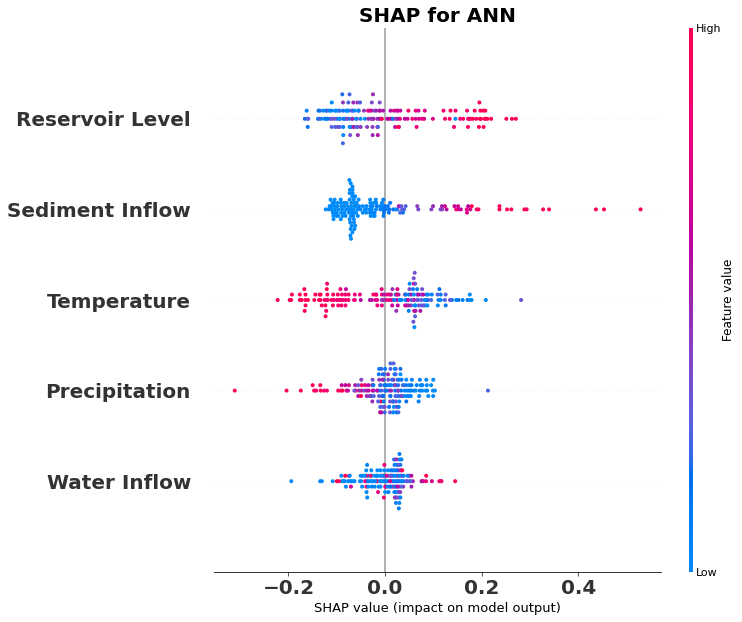

In [54]:
'Effect of input parameters on Pmax'
shap.summary_plot(ANN_shap_values[0], x_df,plot_size=(10,10),show=False,plot_type='dot')
plt.title('SHAP for ANN',weight='bold',size=20)
plt.xticks(size=20,weight='bold')
plt.yticks(size=20,weight='bold')
plt.savefig('SHAP_ANN',dpi=100,bbox_inches='tight')

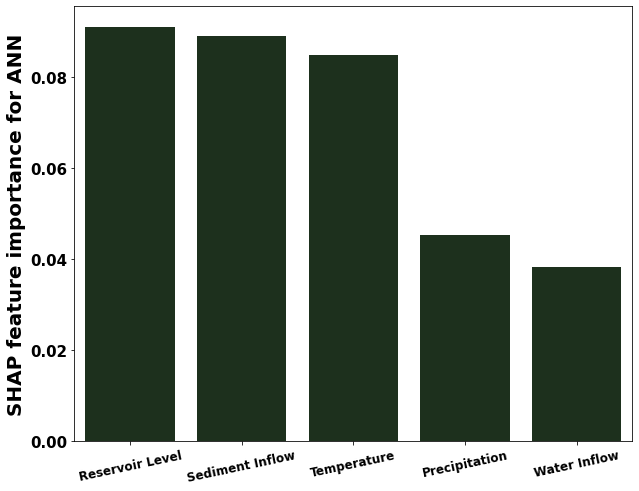

In [55]:
feature_imp = np.mean(np.abs(ANN_shap_values[0]),axis=0)
feature_imp.shape

# top 20 important features
ind = feature_imp.argsort()[-20:]
ind = ind[::-1] #arranging in descending order

np.array(x_df.columns)[ind]
feature_imp[ind]

plt.figure(figsize=(10,8))
plot = sns.barplot(x=np.array(x_df.columns)[ind],y=feature_imp[ind],color=[0.1,0.2,0.1])
plot.set_xticklabels(plot.get_xticklabels(), horizontalalignment='center',size=12)
plt.yticks(size=15,weight='bold')
plt.xticks(size=12,rotation=12,weight='bold')
plt.ylabel('SHAP feature importance for ANN',size=20,weight='bold')
plt.savefig('SHAP Feature Importance ANN',dpi=100,bbox_inches='tight')

In [124]:
Y_act = list(Y_train) + list(Y_test) + list(Y_val)

Y_pred = list(preds_train) + list(preds) + list(preds2)

D = {'Seepage':Y_act}
D2 = {'Seepage':Y_pred}

Y_transformed_act = pd.DataFrame(D)
Y_transformed_pred = pd.DataFrame(D2)

Y_act = Scale_Y.inverse_transform(Y_transformed_act)
Y_pred = Scale_Y.inverse_transform(Y_transformed_pred)

Yy = Y_act[:,0]
Py = Y_pred[:,0]

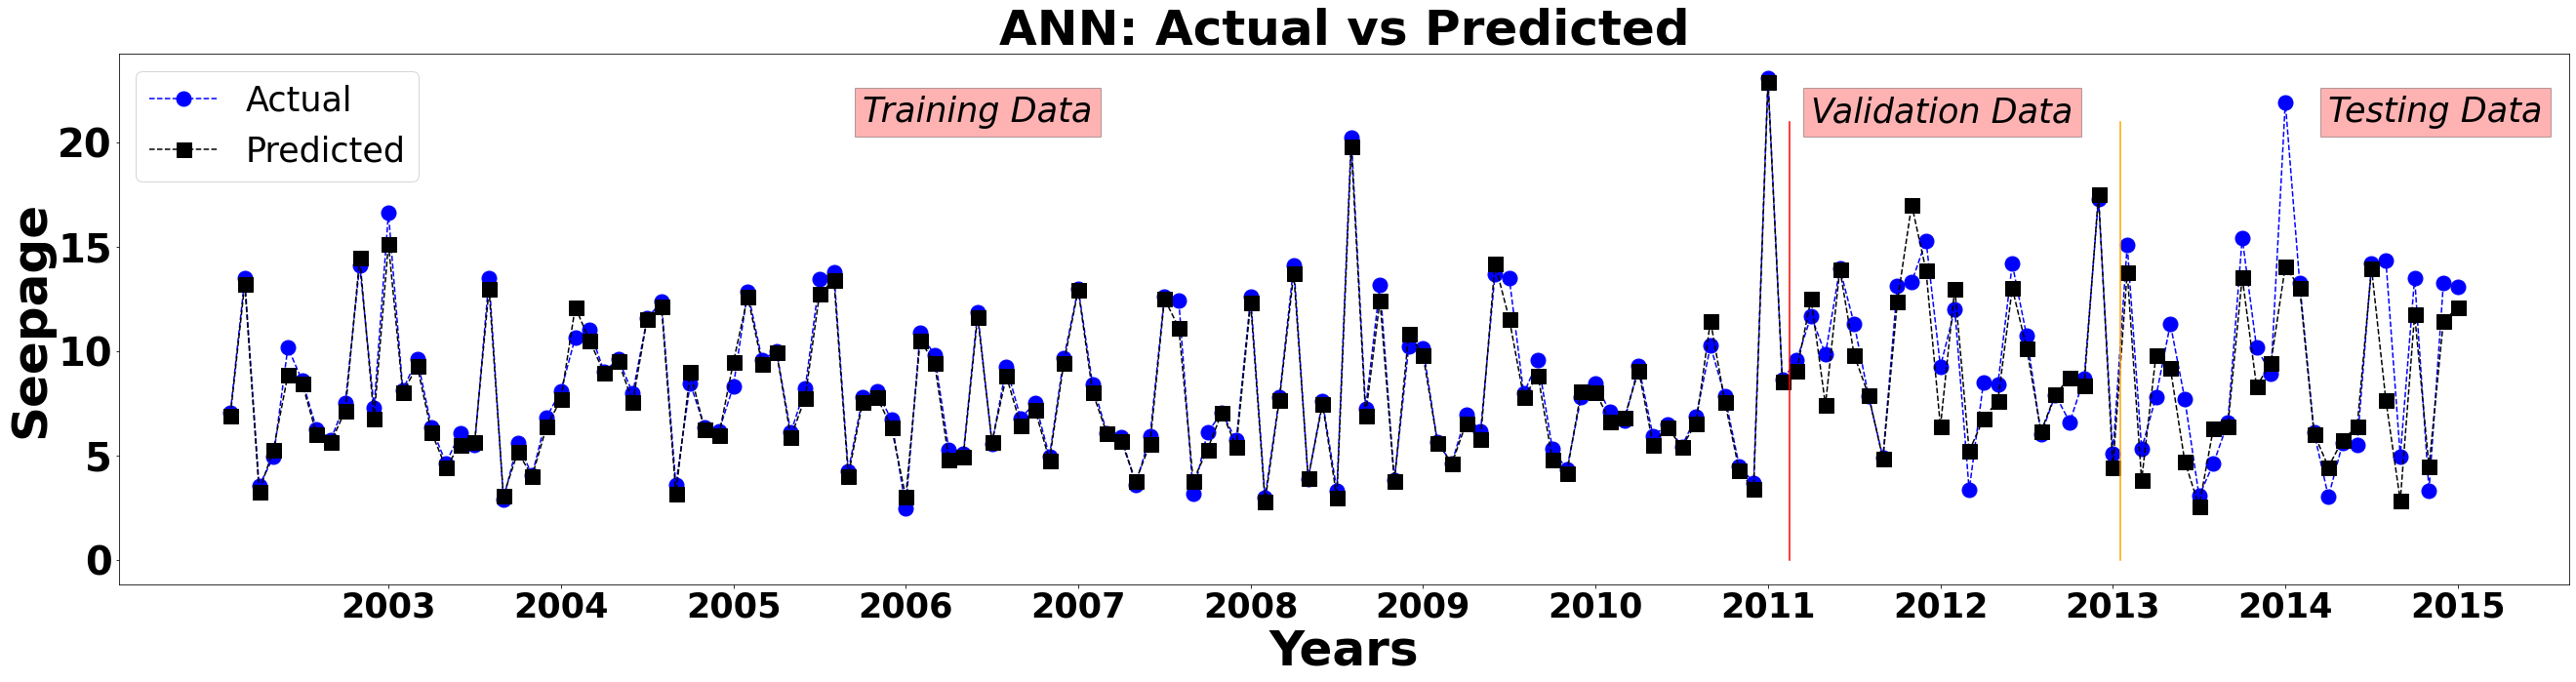

In [125]:
plt.figure(figsize=(45,10))
plt.plot(range(1,len(Data.iloc[:,0])+1),Yy,marker='o',markersize=15,linestyle='dashed',color='blue',label='Actual')
plt.plot(range(1,len(Data.iloc[:,0])+1),Py,marker='s',markersize=15,linestyle='dashed',color='black',label='Predicted')
plt.xlabel('Years',size=50,weight='bold')
plt.ylabel("Seepage",size=50,weight='bold')
plt.title('ANN: Actual vs Predicted',size=50,weight='bold')
plt.xticks(size=35)
plt.xticks(le,Years,weight='bold')
plt.yticks(size=40,weight='bold')
x1, y1 = [109.5, 109.5], [0, 21]
plt.plot(x1,y1,color='red')
x2, y2 = [132.5, 132.5], [0, 21]
plt.plot(x2,y2,color='orange')
plt.legend(prop={"size":35},loc='upper left')
plt.text(45, 21, 'Training Data', style='italic', bbox={'facecolor': 'red', 'alpha': 0.3, 'pad': 8},fontsize=35)
plt.text(111, 21, 'Validation Data', style='italic', bbox={'facecolor': 'red', 'alpha': 0.3, 'pad': 8},fontsize=35)
plt.text(147, 21, 'Testing Data', style='italic', bbox={'facecolor': 'red', 'alpha': 0.3, 'pad': 8},fontsize=35)
plt.savefig('ANN Actual vs Predicted',dpi=100,bbox_inches='tight')
plt.show()

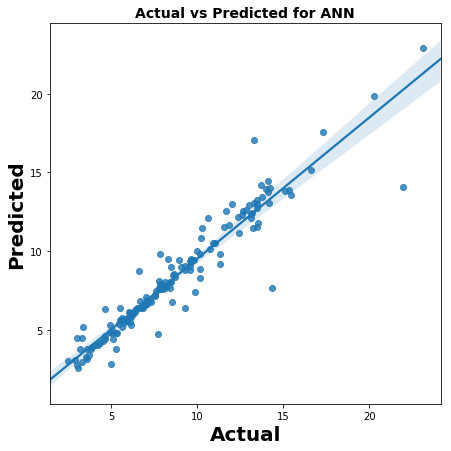

In [123]:
plt.figure(figsize=(7,7))
sns.regplot(Yy,Py)
plt.title('Actual vs Predicted for ANN',size=14,weight='bold')
plt.xlabel('Actual',size=20,weight='bold')
plt.ylabel('Predicted',size=20,weight='bold')
plt.savefig('Regplot ANN',dpi=100,bbox_inches='tight')

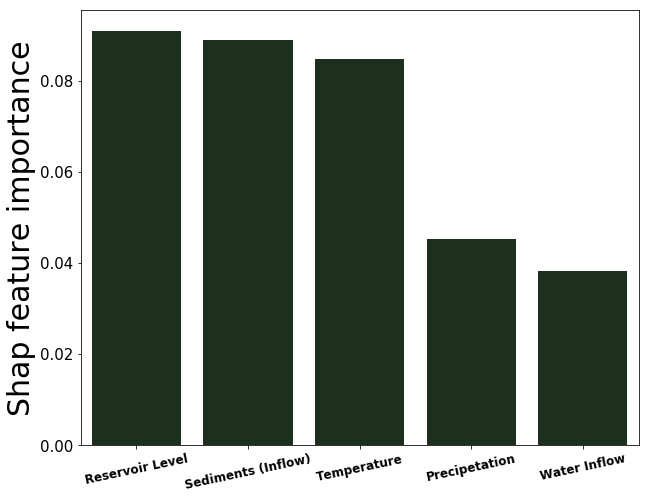

In [169]:
feature_imp = np.mean(np.abs(ANN_shap_values[0]),axis=0)
feature_imp.shape

# top 20 important features
ind = feature_imp.argsort()[-20:]
ind = ind[::-1] #arranging in descending order

np.array(x_df.columns)[ind]
feature_imp[ind]

plt.figure(figsize=(10,8))
plot = sns.barplot(x=np.array(x_df.columns)[ind],y=feature_imp[ind],color=[0.1,0.2,0.1])
plot.set_xticklabels(plot.get_xticklabels(), horizontalalignment='center',size=12)
plt.yticks(size=15)
plt.xticks(size=12,rotation=12,weight='bold')
plt.ylabel('Shap feature importance',size=30)
plt.savefig('SHAP Feature Importance ANN',dpi=100,bbox_inches='tight')

In [220]:
explainer = shap.KernelExplainer(model.predict,X)

Using 156 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [230]:
shap_values = explainer.shap_values(X,nsamples='auto')

  0%|          | 0/156 [00:00<?, ?it/s]

In [231]:
features = Data.columns

In [228]:
model.evaluate(X_test,Y_test)

1/1 [==============================] - 0s 182ms/step - loss: 0.0035 - mae: 0.0491


[0.003473859978839755, 0.049103111028671265]

In [132]:
a = Data['Water Inflow']
Data2 = pd.read_excel('Outflow data.xlsx')

In [133]:
b = Data2['Outflow']

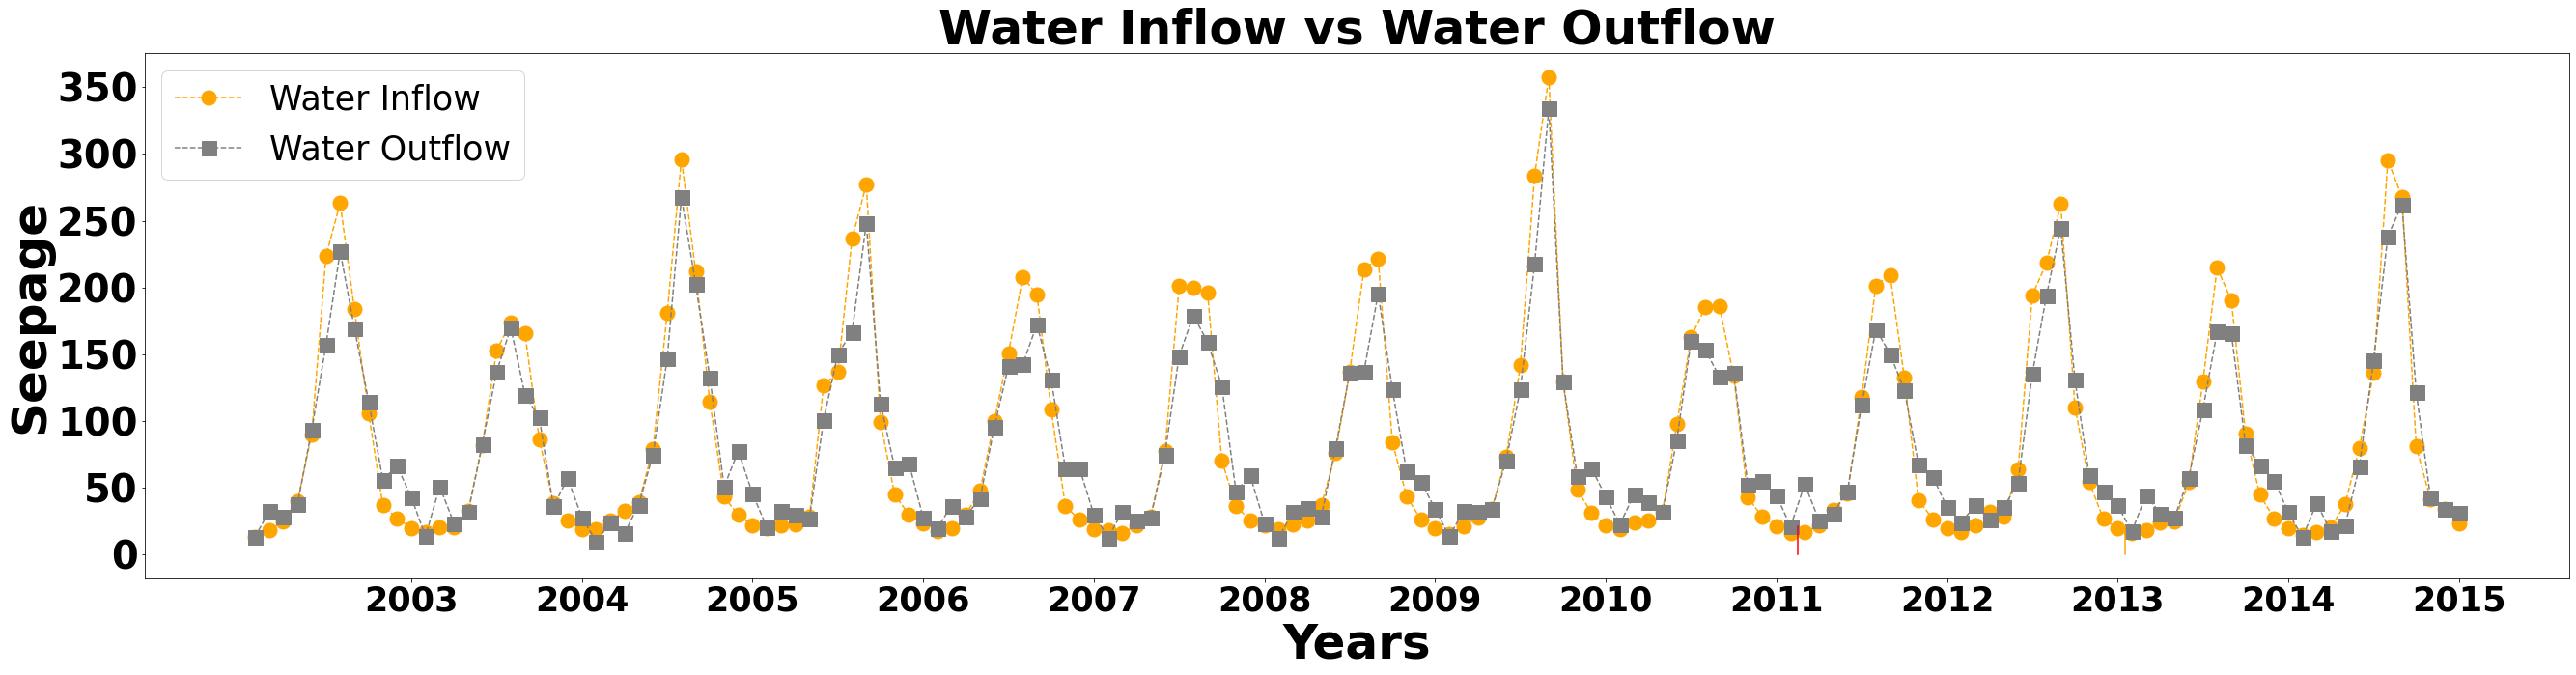

In [139]:
plt.figure(figsize=(45,10))
plt.plot(range(1,len(Data.iloc[:,0])+1),a,marker='o',markersize=15,linestyle='dashed',color='orange',label='Water Inflow')
plt.plot(range(1,len(Data.iloc[:,0])+1),b,marker='s',markersize=15,linestyle='dashed',color='grey',label='Water Outflow')
plt.xlabel('Years',size=50,weight='bold')
plt.ylabel("Seepage",size=50,weight='bold')
plt.title('Water Inflow vs Water Outflow',size=50,weight='bold')
plt.xticks(size=35)
plt.xticks(le,Years,weight='bold')
plt.yticks(size=40,weight='bold')
x1, y1 = [109.5, 109.5], [0, 21]
plt.plot(x1,y1,color='red')
x2, y2 = [132.5, 132.5], [0, 21]
plt.plot(x2,y2,color='orange')
plt.legend(prop={"size":35},loc='upper left')
plt.savefig('I vs O years',dpi=100,bbox_inches='tight')
plt.show()

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


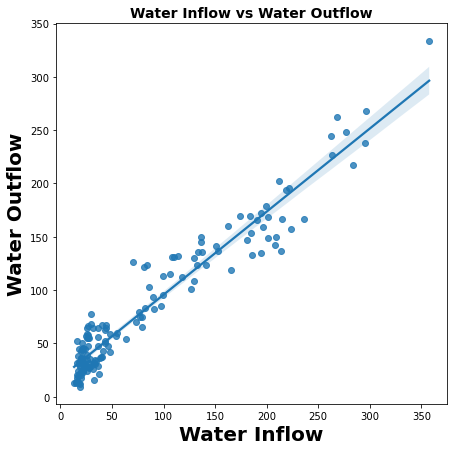

In [138]:
plt.figure(figsize=(7,7))
sns.regplot(a,b)
plt.title('Water Inflow vs Water Outflow',size=14,weight='bold')
plt.xlabel('Water Inflow',size=20,weight='bold')
plt.ylabel('Water Outflow',size=20,weight='bold')
plt.savefig('I vs O',dpi=100,bbox_inches='tight')